   Waterbody        Station Description   Station       Date  County  \
0          0  CHOWAN RIVER AT EDENHOUSE  D9490000 1999-08-12  BERTIE   
1          0  CHOWAN RIVER AT EDENHOUSE  D9490000 1999-08-12  BERTIE   
2          0  CHOWAN RIVER AT EDENHOUSE  D9490000 1999-08-12  BERTIE   
3          0  CHOWAN RIVER AT EDENHOUSE  D9490000 1999-08-12  BERTIE   
4          0  CHOWAN RIVER AT EDENHOUSE  D9490000 1999-08-12  BERTIE   

  Sample ID#  AlgalGroup  Genus  Species  Cell Density (cells/ml)  \
0       333W           4    125       73                     1165   
1       333W           4     11       27                    15494   
2       333W           1    106       95                      233   
3       333W           1      8       35                      116   
4       333W           2     83       66                      582   

   Biovolume (mm3/m3)  Latitude  Longitude  
0                   0    36.047    -76.697  
1                   1    36.047    -76.697  
2                

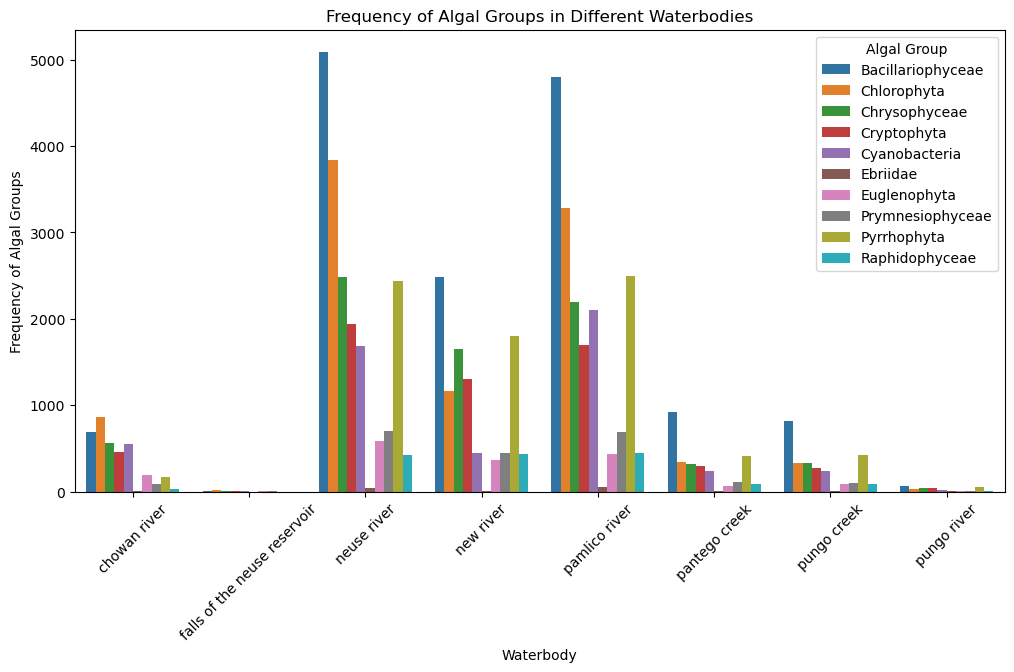

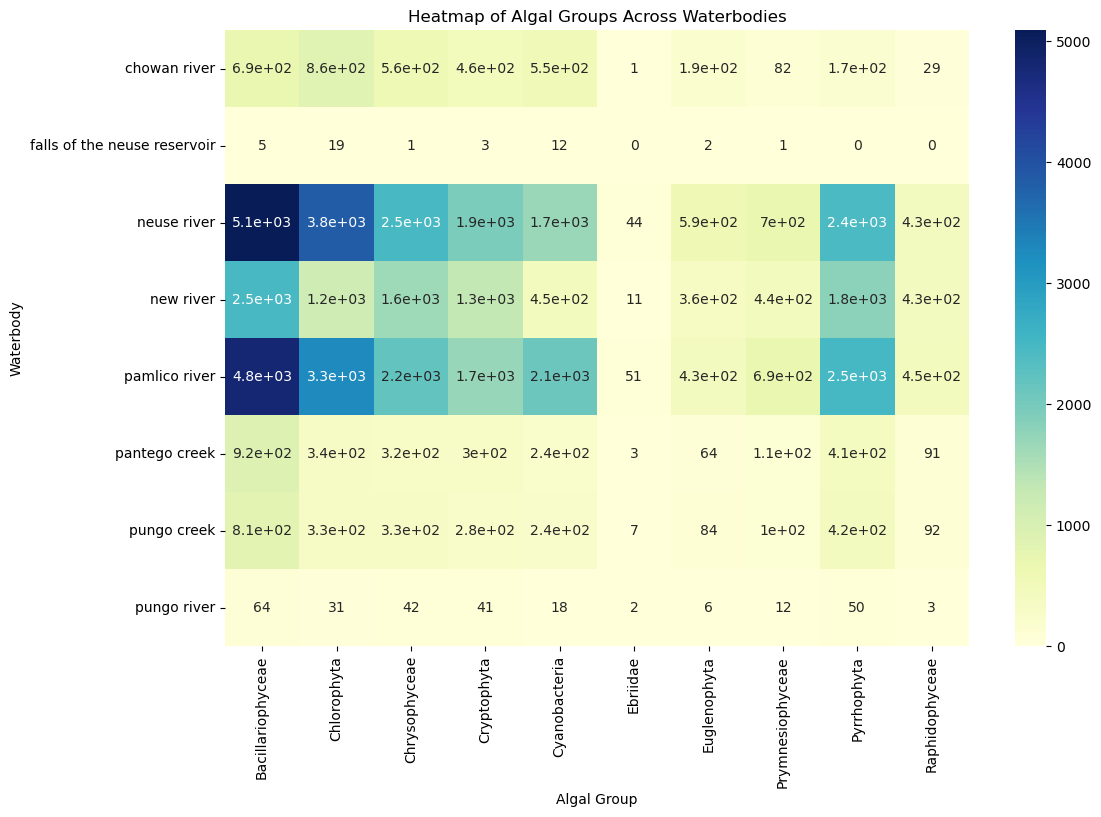

C:\Users\cbeau\AppData\Local\Temp\ipykernel_23708\732147774.py:120: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.



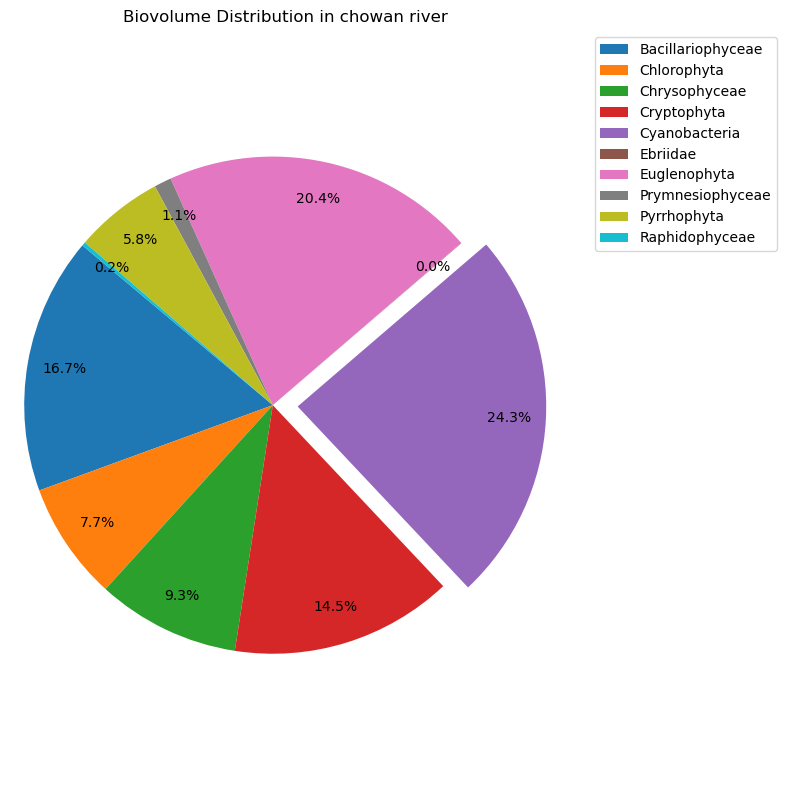

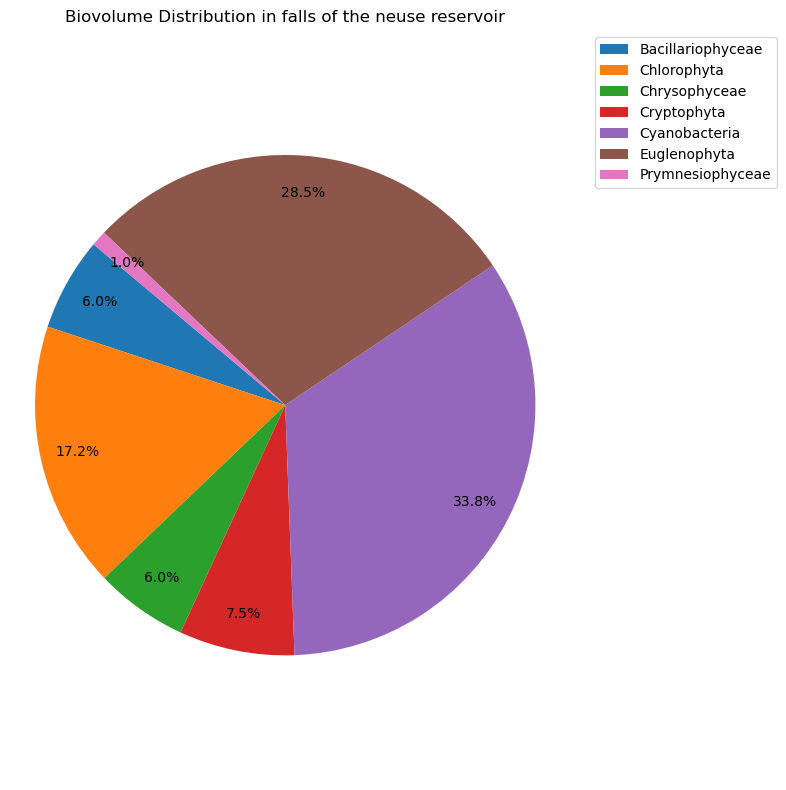

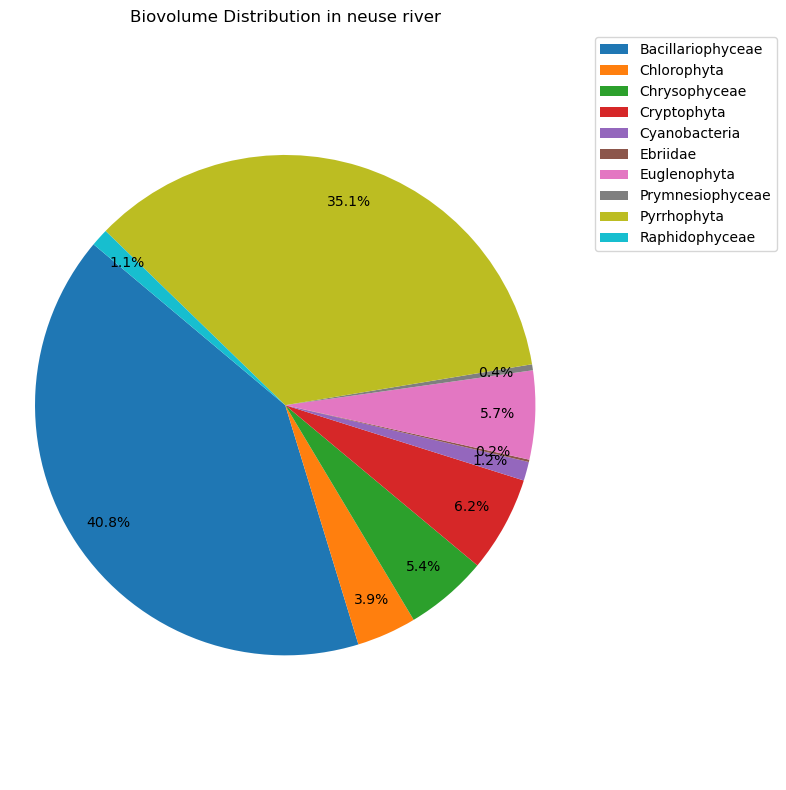

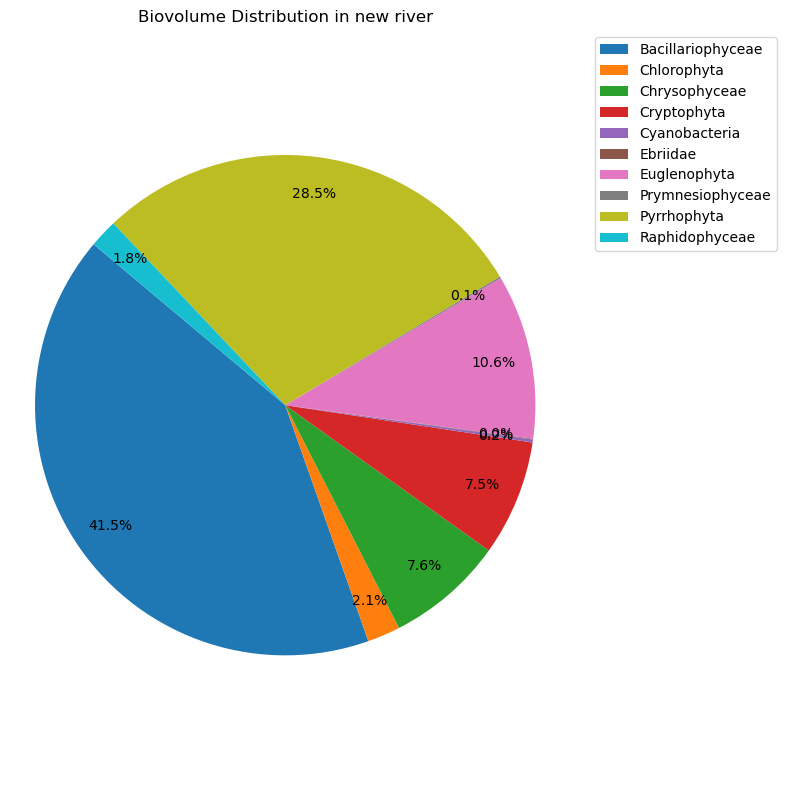

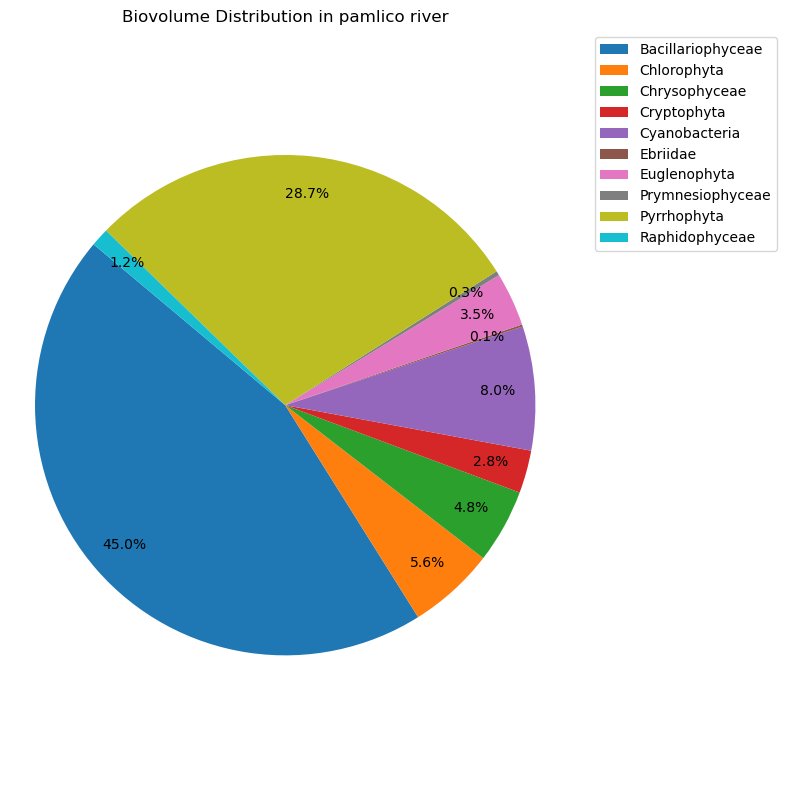

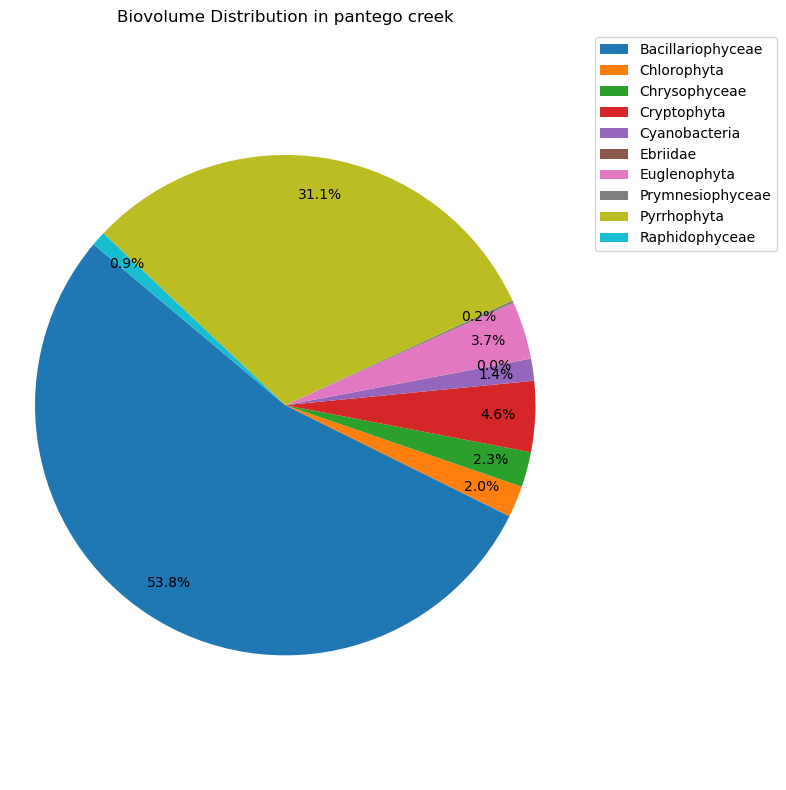

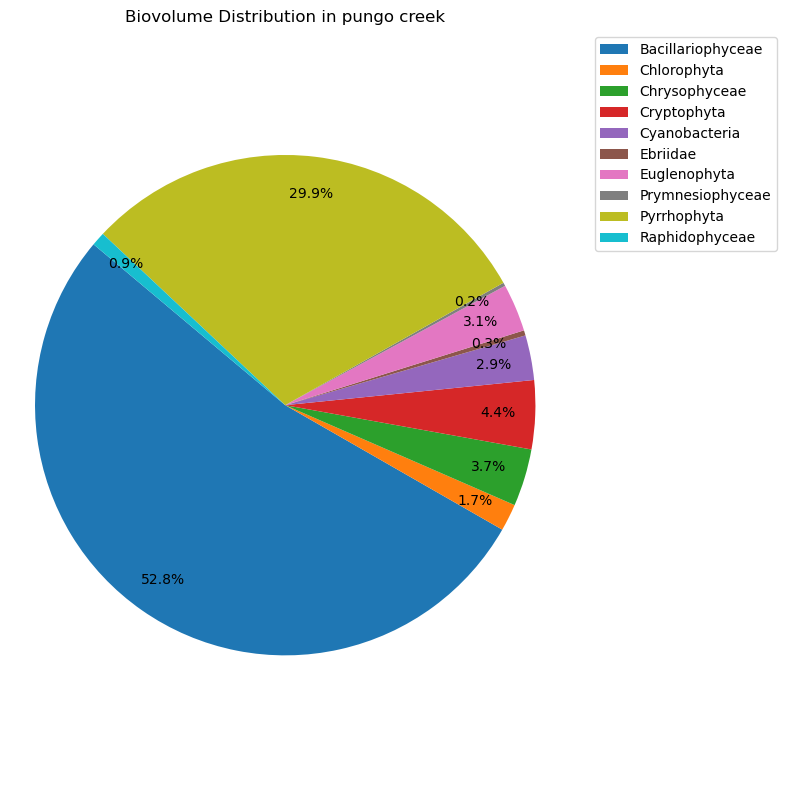

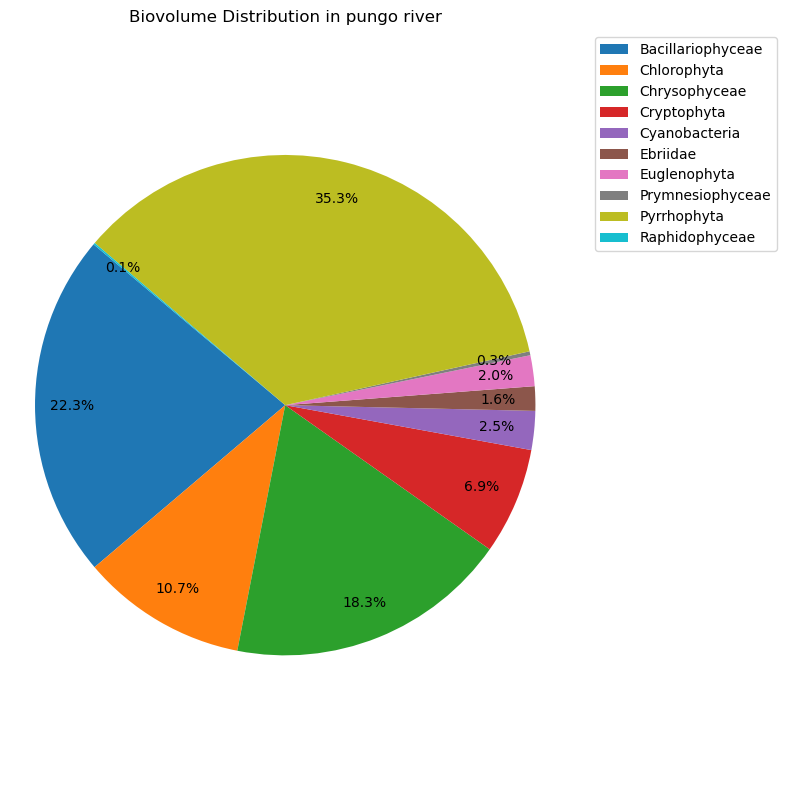

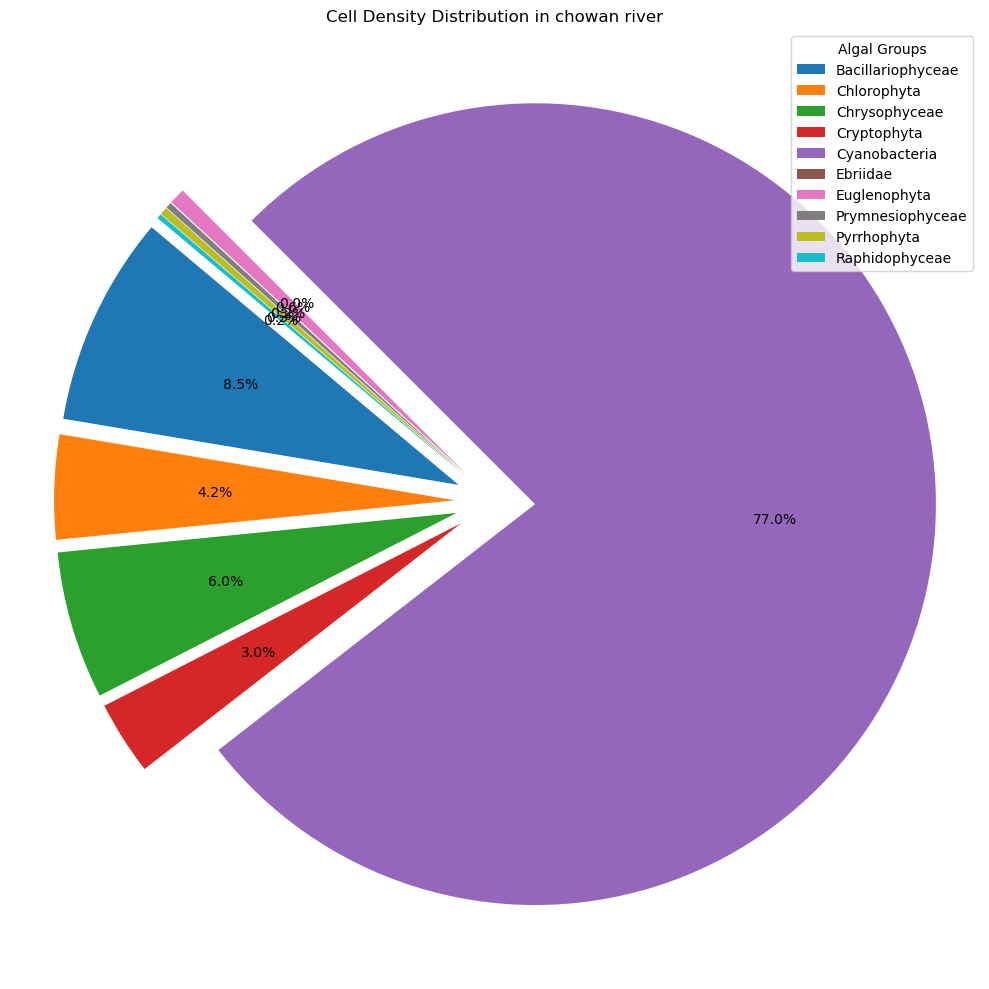

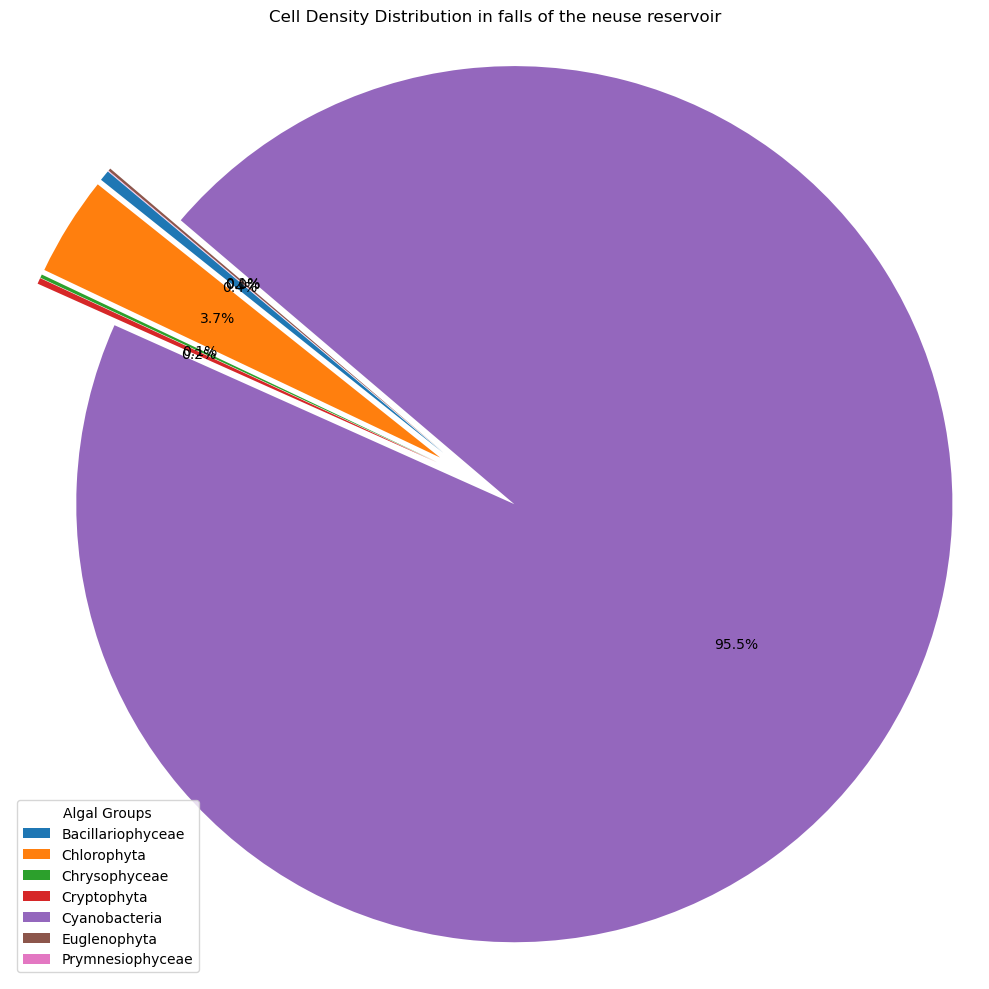

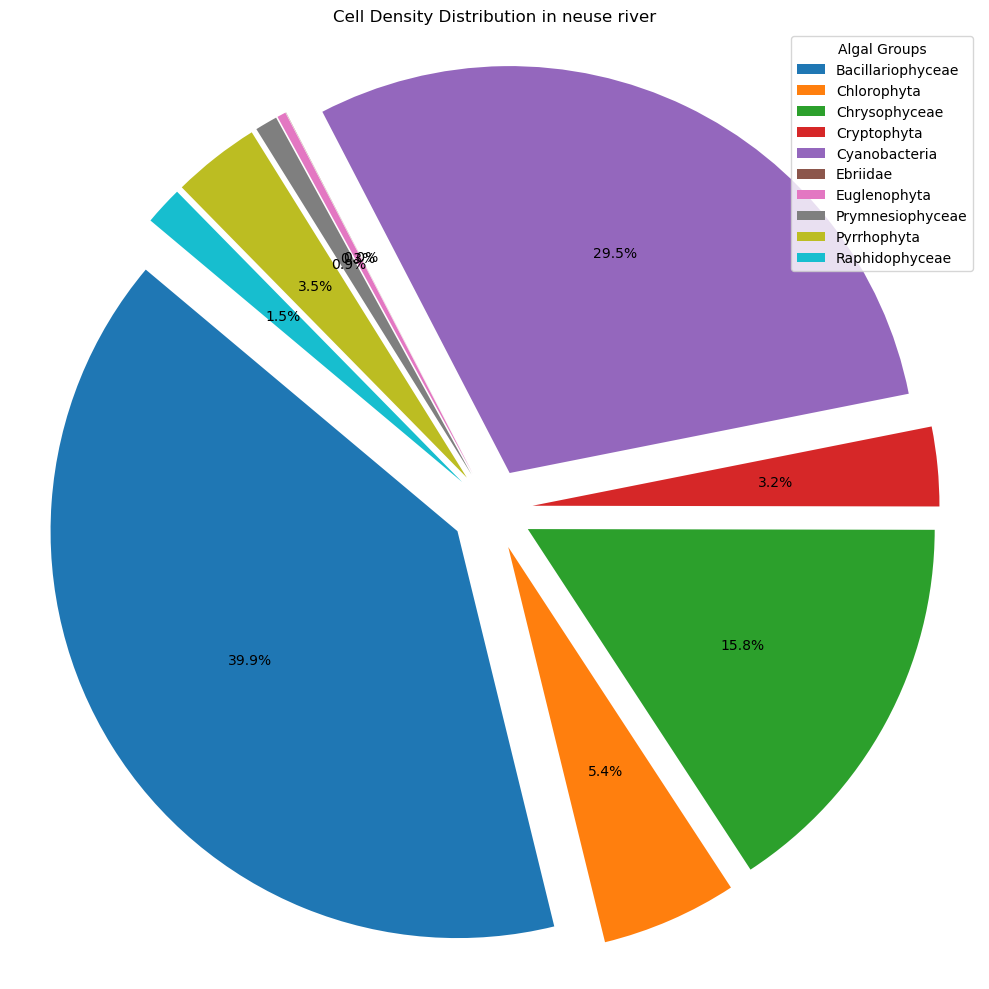

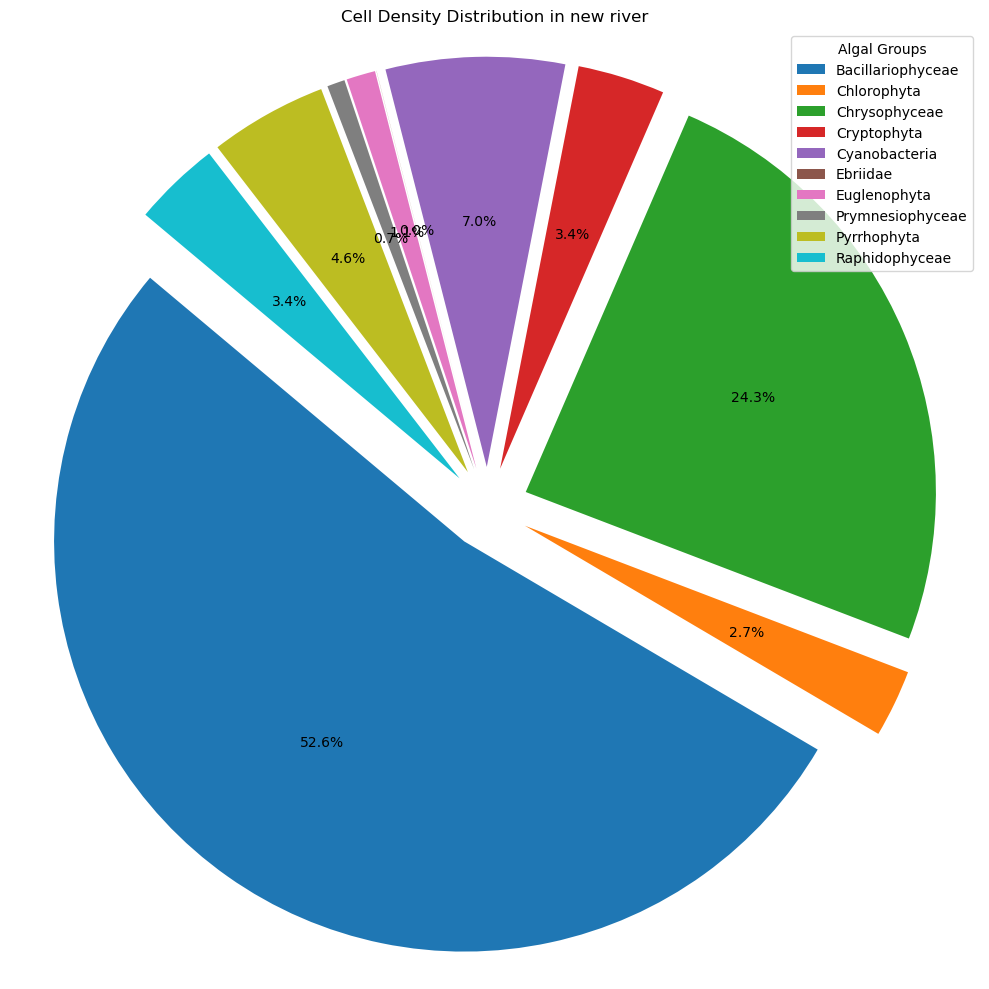

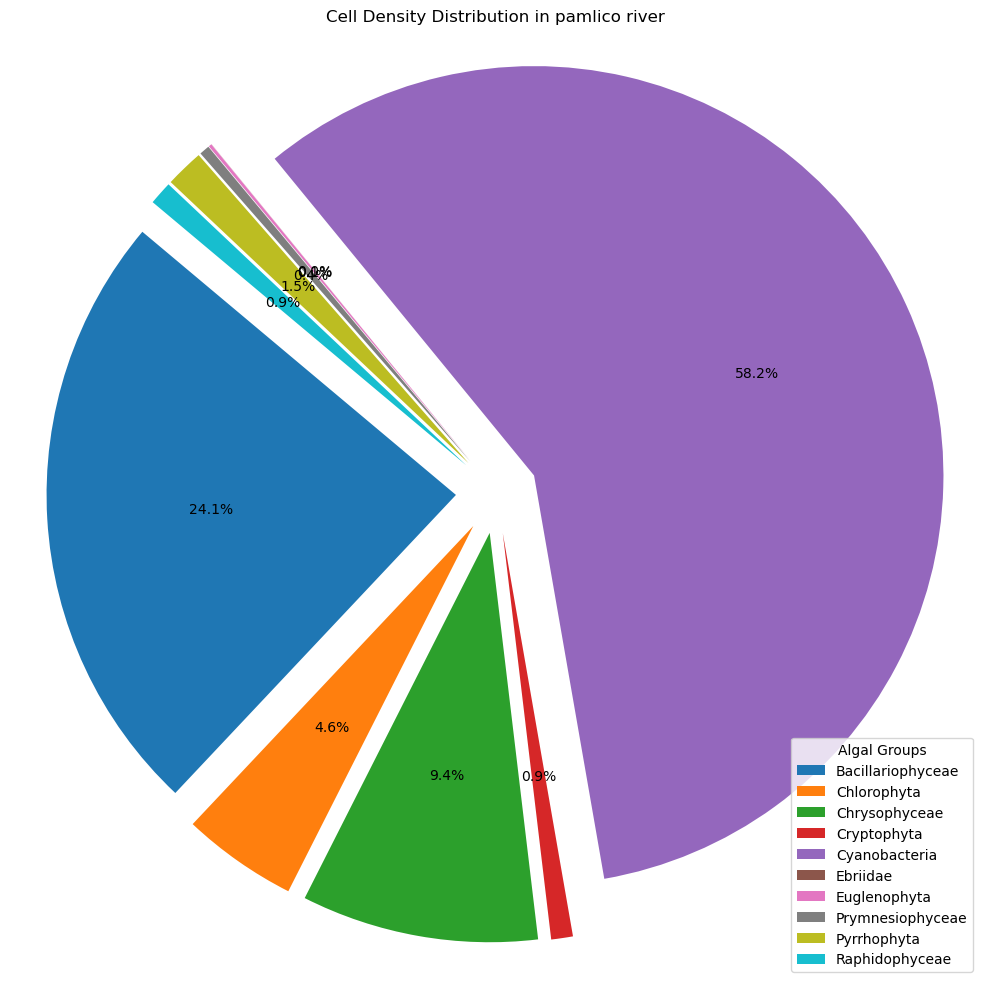

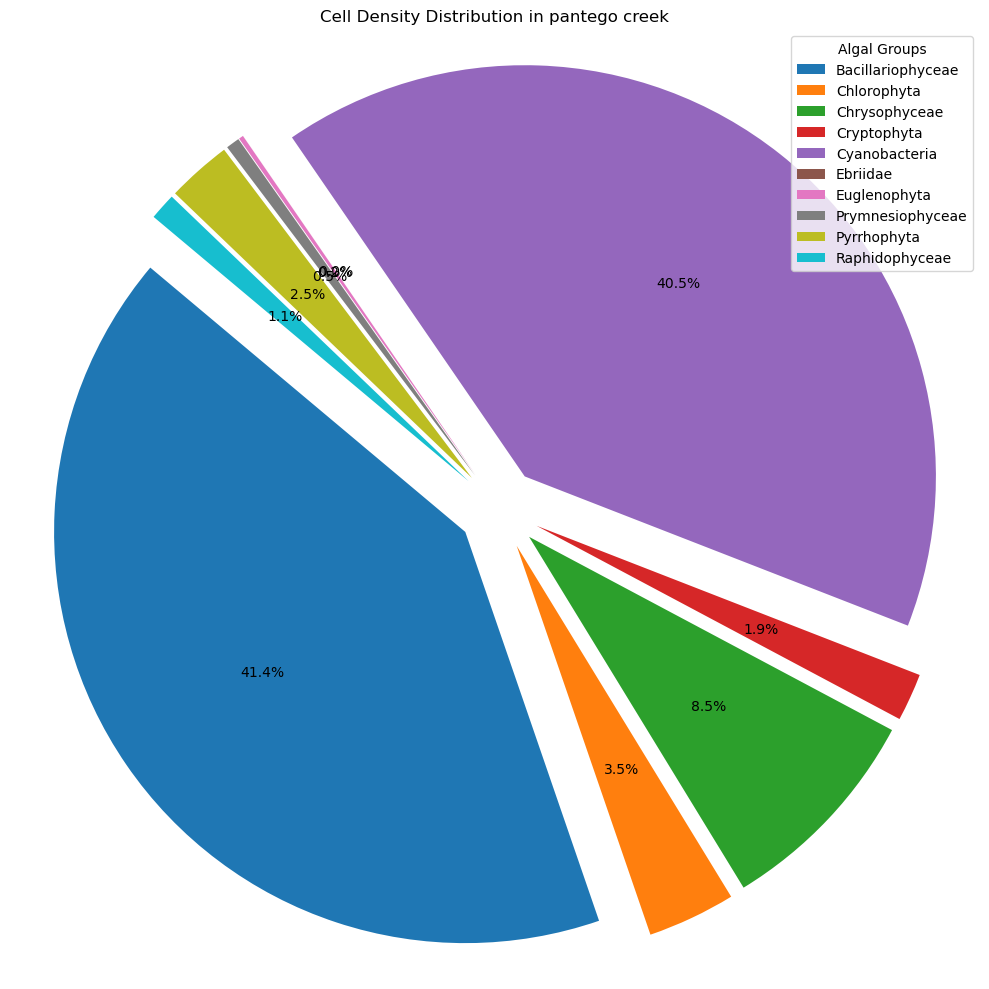

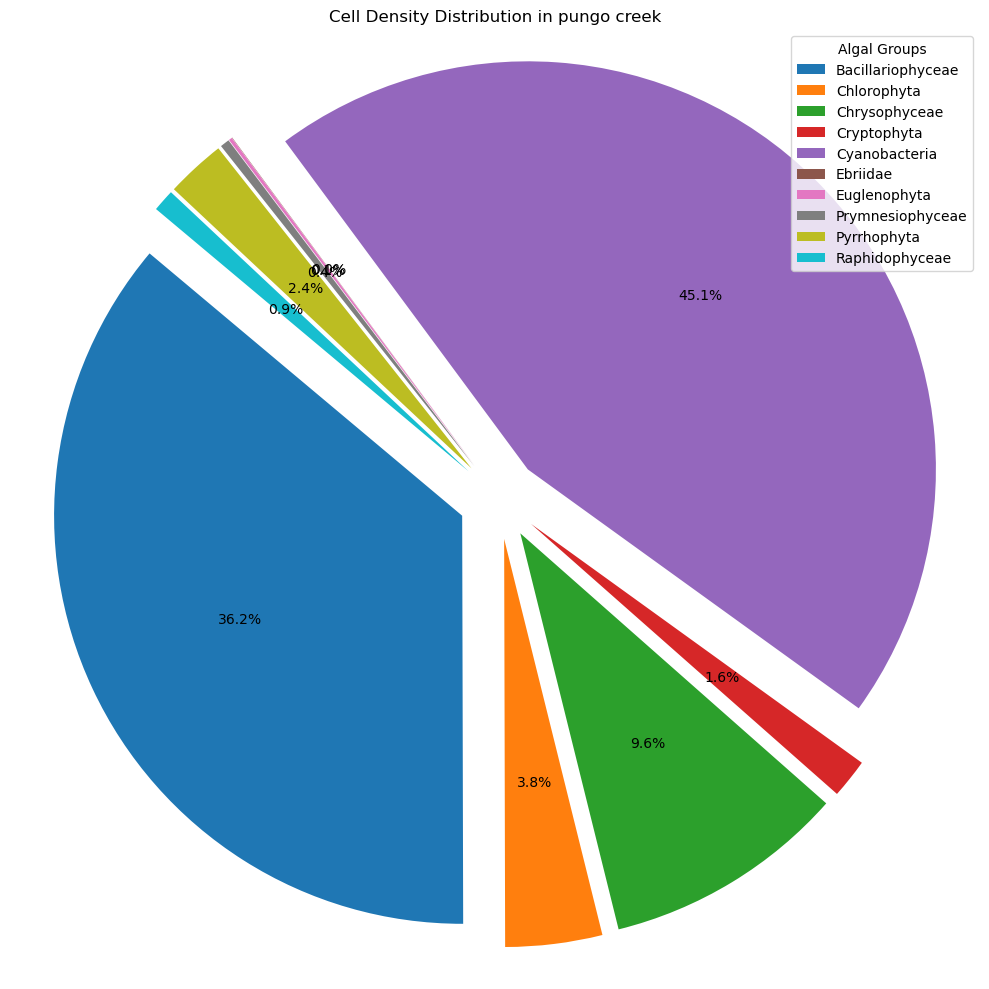

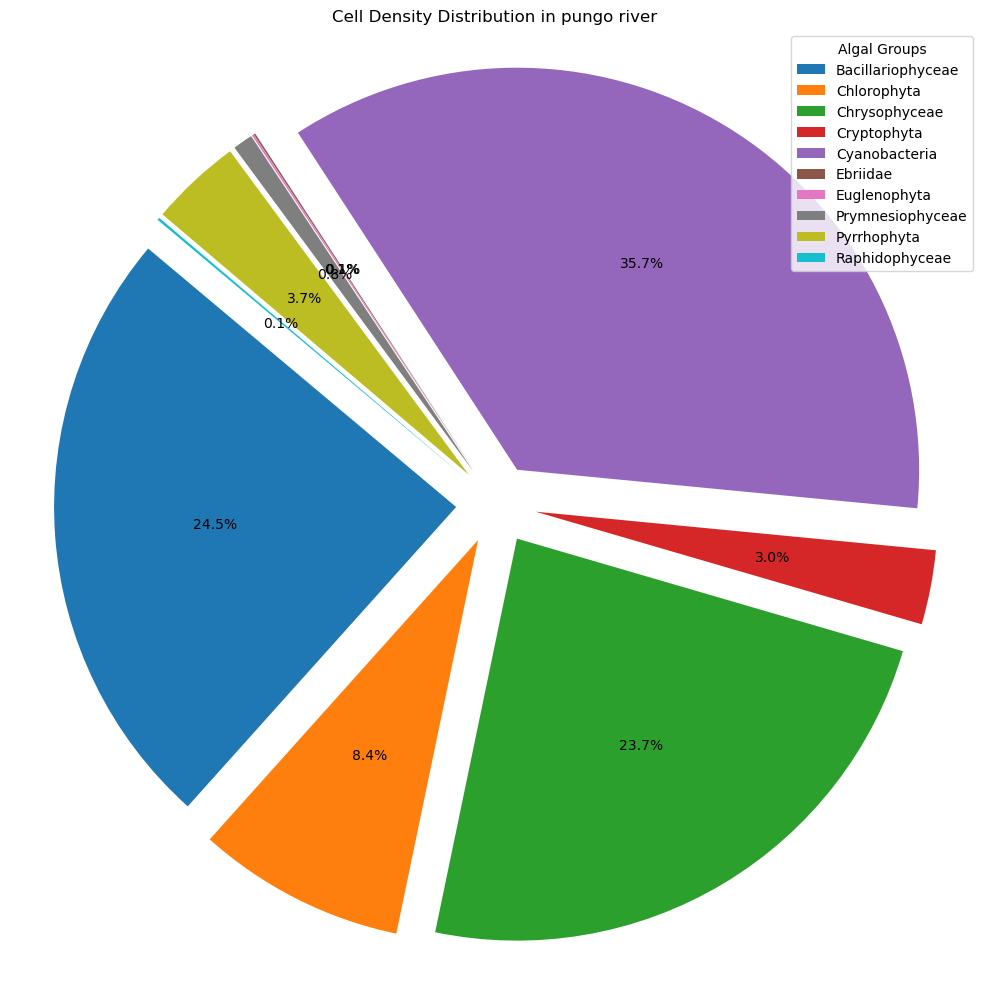

In [12]:
# Really need these
import pandas as pd 
import numpy as np
from numpy import *
from scipy.stats import skew
from statsmodels.tsa.seasonal import STL


# Handy for debugging
import gc
import time
import warnings
import os

# Date stuff
from datetime import datetime
from datetime import timedelta

# Nice graphing tools
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.offline as py
import plotly.tools as tls
import plotly.graph_objs as go
import plotly.tools as tls
from matplotlib.dates import MonthLocator, YearLocator, DateFormatter
import seaborn as sns
from IPython.display import display, clear_output

# Machine learning tools
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix

# Performance measures
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from calendar import month_abbr
import scipy.stats as stats
import csv
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
import folium
from folium.plugins import MarkerCluster
import ipywidgets as widgets
from IPython.display import display
#############################################################################################################

Path = r"C:\Users\cbeau\Downloads\UNCW\Albermarle Sound Algae\NC estuarine river data 2000-2023 (1).xlsx"
ALG = pd.read_excel(Path)

# Correct the format string to match the date format in your data
ALG['Date'] = pd.to_datetime(ALG['Date'], format='%m/%d/%y')

# Convert 'Waterbody' column to lowercase to ignore capitalization differences
ALG['Waterbody'] = ALG['Waterbody'].str.lower()

# Initialize LabelEncoder
le = LabelEncoder()

# List of categorical columns to encode, 'Waterbody' is now pre-processed
categorical_columns = ['AlgalGroup', 'Genus', 'Waterbody', 'Species']

# Dictionary to hold mappings for each categorical column
category_mappings = {}

# Apply Label Encoding to each categorical column and store the mappings
for column in categorical_columns:
    ALG[column] = le.fit_transform(ALG[column])
    # Store the mapping of encoded values back to original categories
    category_mappings[column] = {index: label for index, label in enumerate(le.classes_)}

# Display the first few rows to check the results
print(ALG.head())
####################################################################################################################
# Reverse the encoding for visualization
for column in categorical_columns:
    ALG[column + 'Name'] = ALG[column].map(category_mappings[column])

# Count the occurrences of each algal group in each waterbody using the original names
group_counts = ALG.groupby(['WaterbodyName', 'AlgalGroupName']).size().reset_index(name='counts')

# Plotting the frequency of Algal Groups in different waterbodies
plt.figure(figsize=(12, 6))
sns.barplot(x='WaterbodyName', y='counts', hue='AlgalGroupName', data=group_counts)
plt.title('Frequency of Algal Groups in Different Waterbodies')
plt.xlabel('Waterbody')
plt.ylabel('Frequency of Algal Groups')
plt.legend(title='Algal Group')
plt.xticks(rotation=45)
plt.show()
###################################################################################################
# Create a pivot table using the original names
pivot_table = ALG.pivot_table(index='WaterbodyName', columns='AlgalGroupName', aggfunc='size', fill_value=0)

# Plotting the heatmap of algal groups across waterbodies
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu')
plt.title('Heatmap of Algal Groups Across Waterbodies')
plt.xlabel('Algal Group')
plt.ylabel('Waterbody')
plt.show()
#########################################################################################################
# Ensure 'Date' is a datetime object for further analysis
ALG['Month'] = ALG['Date'].dt.month

# Find the most frequent Algal group for each combination of month, latitude, and longitude
dominant_algal_group = ALG.groupby(['Month', 'Latitude', 'Longitude'])['AlgalGroup'].agg(lambda x: stats.mode(x)[0][0]).reset_index()

# Map the encoded algal groups back to their names
dominant_algal_group['DominantAlgalGroupName'] = dominant_algal_group['AlgalGroup'].map(category_mappings['AlgalGroup'])

# Rename the column for clarity
dominant_algal_group.rename(columns={'AlgalGroup': 'DominantAlgalGroup'}, inplace=True)

# Plotting the most frequent Algal Group for each year at each location
fig = px.scatter_geo(dominant_algal_group,
                     lat='Latitude',
                     lon='Longitude',
                     color='DominantAlgalGroupName',
                     hover_name='DominantAlgalGroupName',
                     size=[1]*len(dominant_algal_group),  # Optional: all points same size
                     animation_frame='Month',
                     projection="natural earth",
                     title="Most Frequent Algal Group for Each Month at Each Location")

fig.show()
########################################################################################################
# Group by 'WaterbodyName' and 'AlgalGroupName' and sum 'Biovolume'
waterbody_group = ALG.groupby(['WaterbodyName', 'AlgalGroupName'])['Biovolume (mm3/m3)'].sum().reset_index()

# Get unique waterbody names
unique_waterbodies = waterbody_group['WaterbodyName'].unique()

# Plot pie chart for each waterbody focusing on 'Biovolume (mm3/m3)'
for waterbody in unique_waterbodies:
    # Filter data for the current waterbody
    waterbody_data = waterbody_group[waterbody_group['WaterbodyName'] == waterbody]
    
    # Check if there is data to plot
    if not waterbody_data.empty:
        # Prepare to explode slices slightly
        explode = [0.1 if i == waterbody_data['Biovolume (mm3/m3)'].idxmax() else 0 for i in range(len(waterbody_data))]
        
        # Plot pie chart
        plt.figure(figsize=(8, 8))
        patches, texts, autotexts = plt.pie(waterbody_data['Biovolume (mm3/m3)'], autopct='%1.1f%%', startangle=140, explode=explode, pctdistance=0.85)
        
        # Improve legibility
        for text in texts:
            text.set_color('black')
        for autotext in autotexts:
            autotext.set_color('black')
        
        # Add legend outside the pie
        plt.legend(patches, waterbody_data['AlgalGroupName'], loc='best', bbox_to_anchor=(1.05, 1))
        
        plt.title(f'Biovolume Distribution in {waterbody}')
        plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
        plt.tight_layout()
        plt.show()
    else:
        print(f"No data available for {waterbody}")
# Group by 'WaterbodyName' and 'AlgalGroupName' and sum 'Cell Density (cells/ml)'
waterbody_group = ALG.groupby(['WaterbodyName', 'AlgalGroupName'])['Cell Density (cells/ml)'].sum().reset_index()
######################################################################################################################
#Cell Density pie charts
# Get unique waterbody names
unique_waterbodies = waterbody_group['WaterbodyName'].unique()

# Plot pie chart for each waterbody focusing on 'Cell Density (cells/ml)'
for waterbody in unique_waterbodies:
    # Filter data for the current waterbody
    waterbody_data = waterbody_group[waterbody_group['WaterbodyName'] == waterbody]
    
    # Check if there is data to plot
    if not waterbody_data.empty:
        # Explode slices a little bit
        explode = [0.1] * len(waterbody_data)  # This creates a small separation for each slice
        
        # Plot pie chart with a larger figure size and explode slices
        plt.figure(figsize=(10, 10))  # Increased figure size
        patches, texts, autotexts = plt.pie(waterbody_data['Cell Density (cells/ml)'], autopct='%1.1f%%', startangle=140, explode=explode)
        
        # Improve legibility
        for text in texts:
            text.set_color('black')
        for autotext in autotexts:
            autotext.set_color('black')  # Set the percentage text color
        
        plt.title(f'Cell Density Distribution in {waterbody}', color='black')
        
        # Use a legend to avoid clutter
        plt.legend(patches, waterbody_data['AlgalGroupName'], title="Algal Groups", loc="best")
        
        plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        plt.tight_layout()
        plt.show()
    else:
        print(f"No data available for {waterbody}")



C:\Users\cbeau\AppData\Local\Temp\ipykernel_23708\953802838.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\cbeau\AppData\Local\Temp\ipykernel_23708\953802838.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



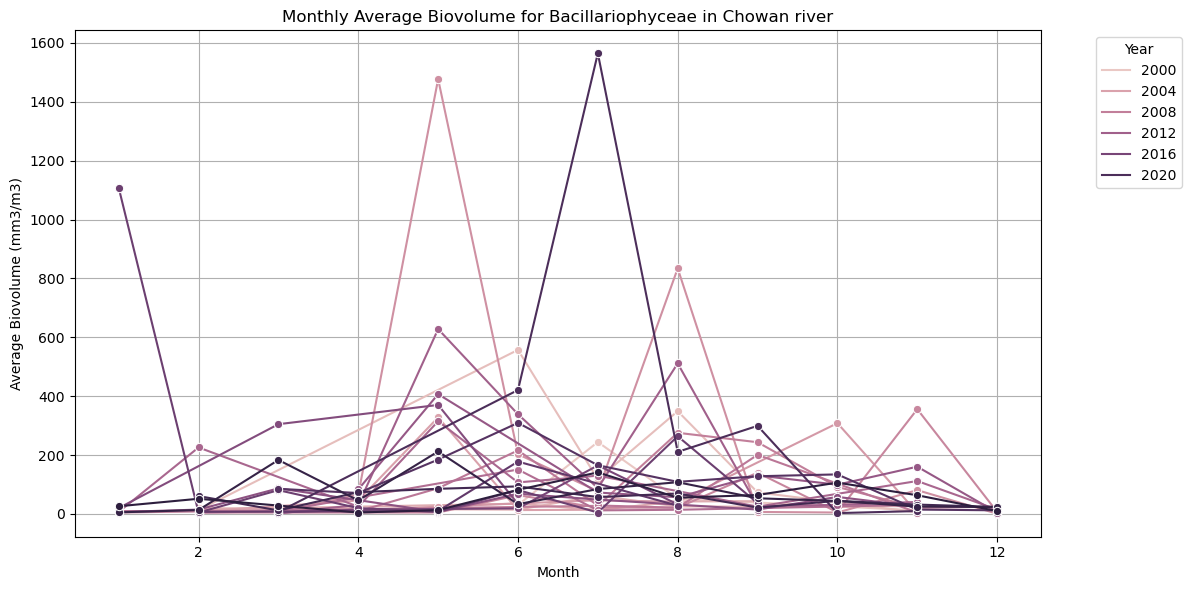

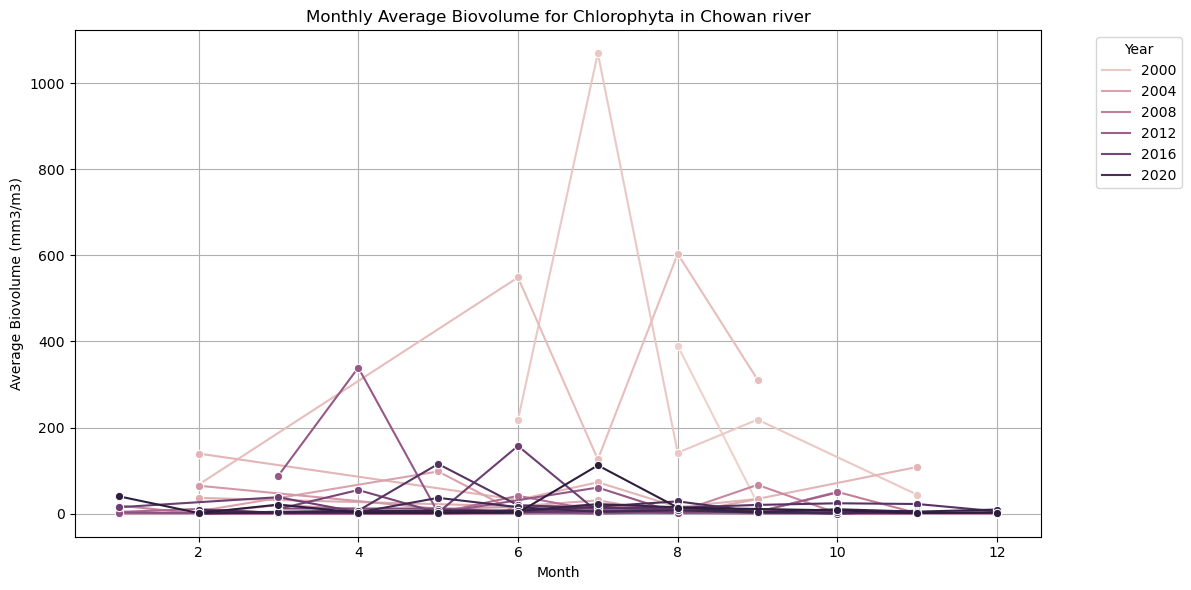

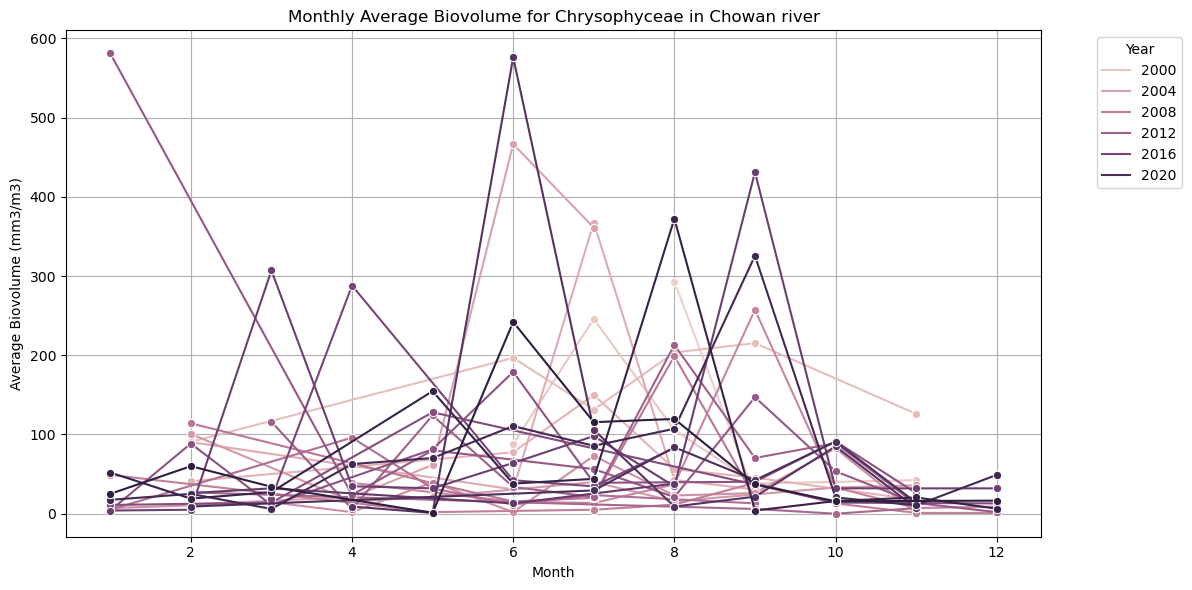

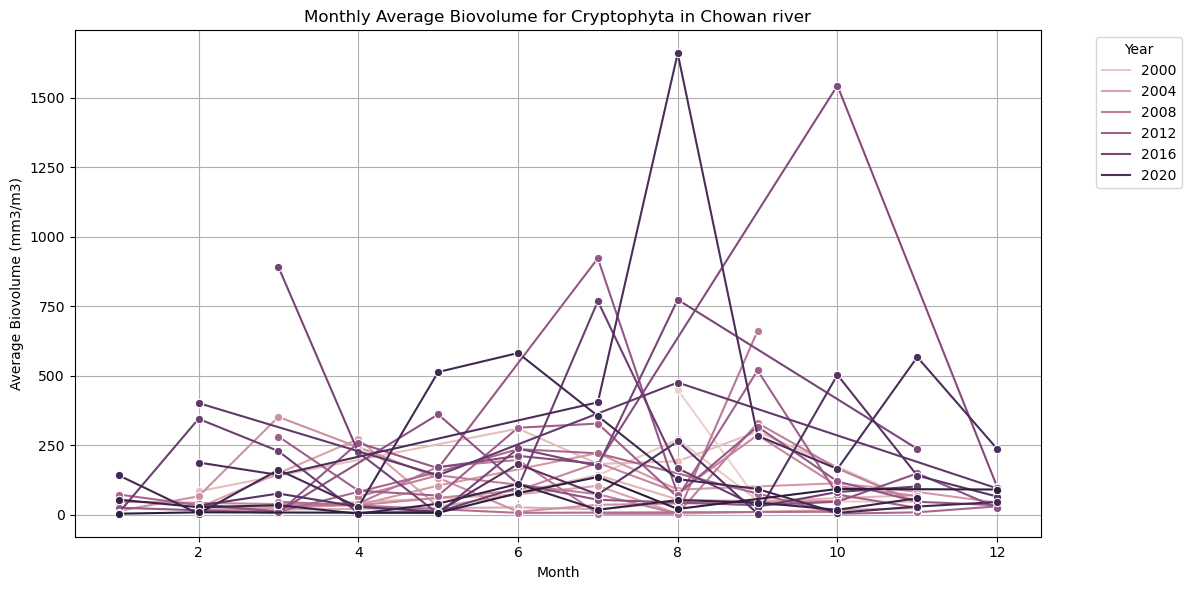

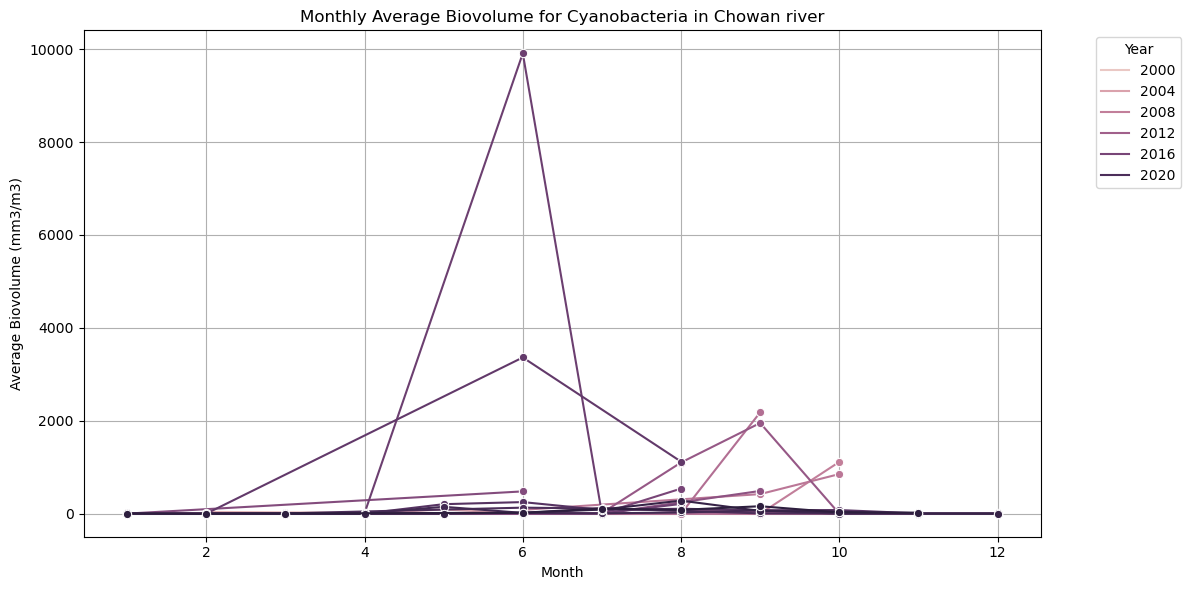

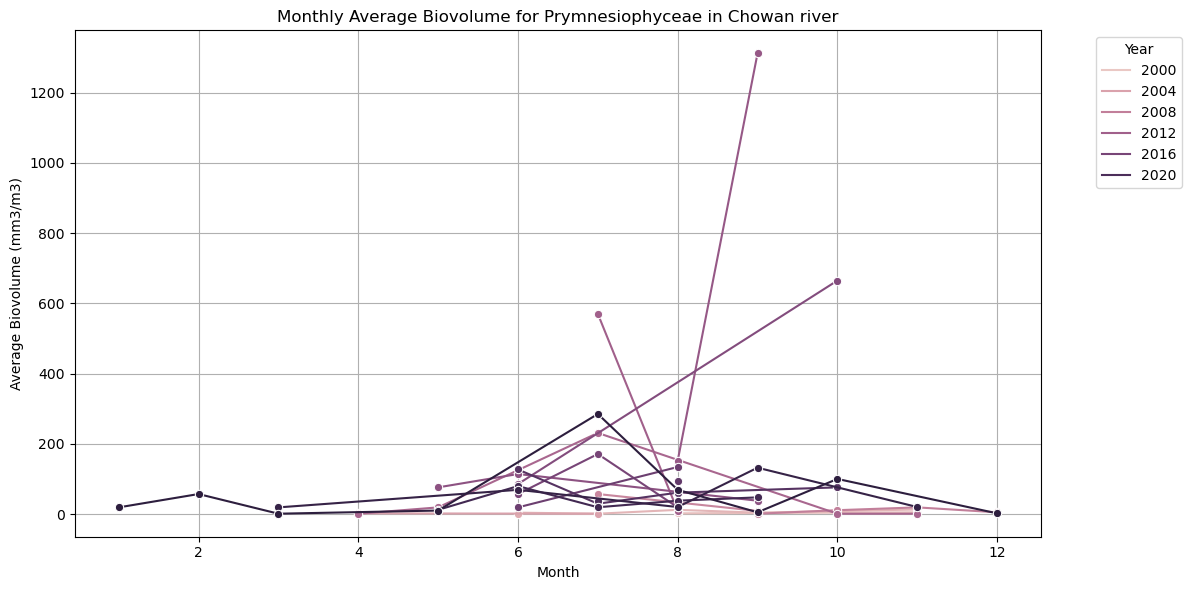

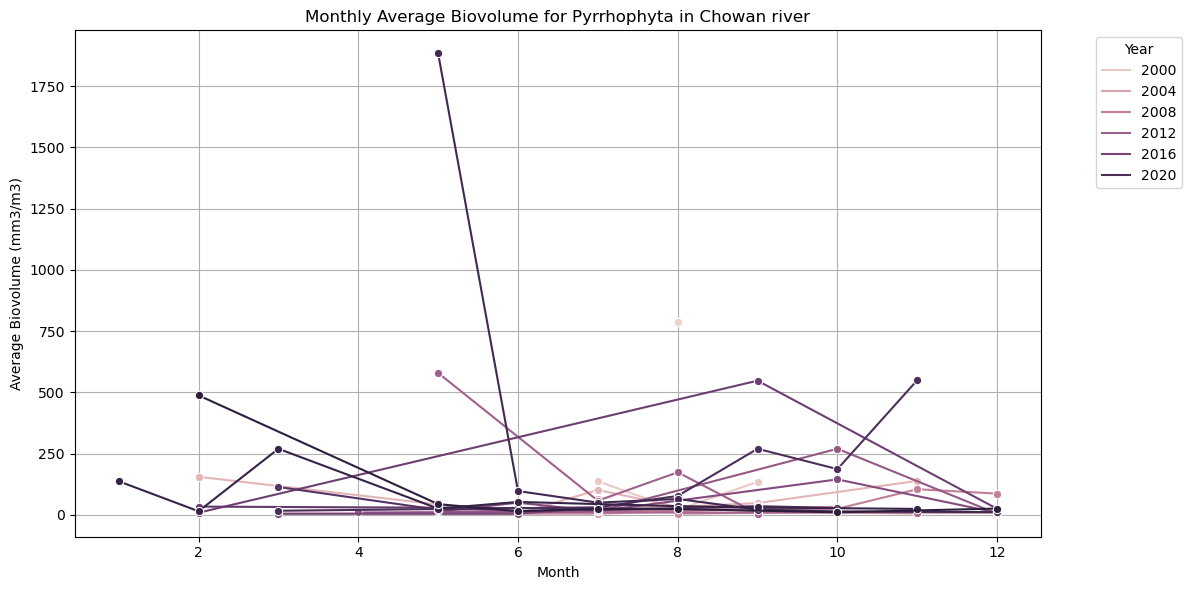

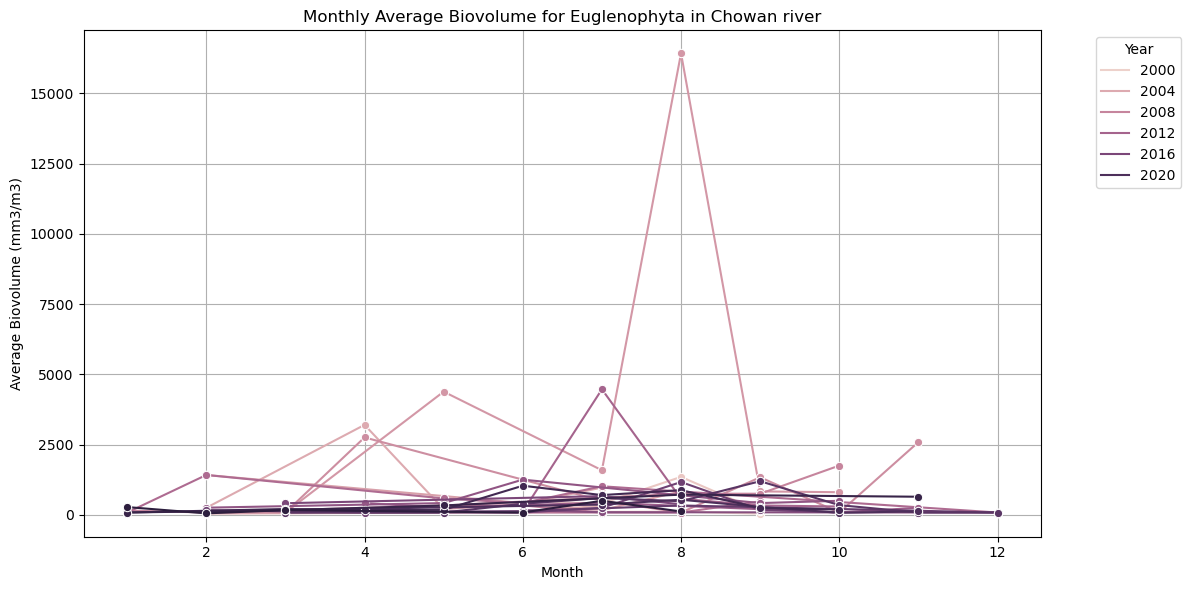

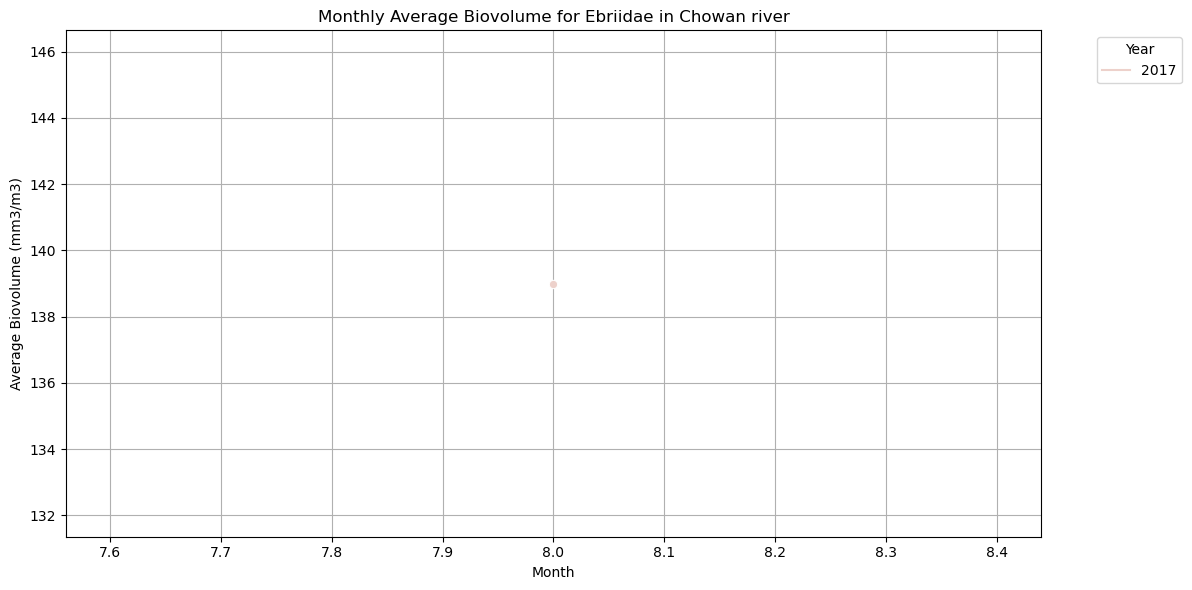

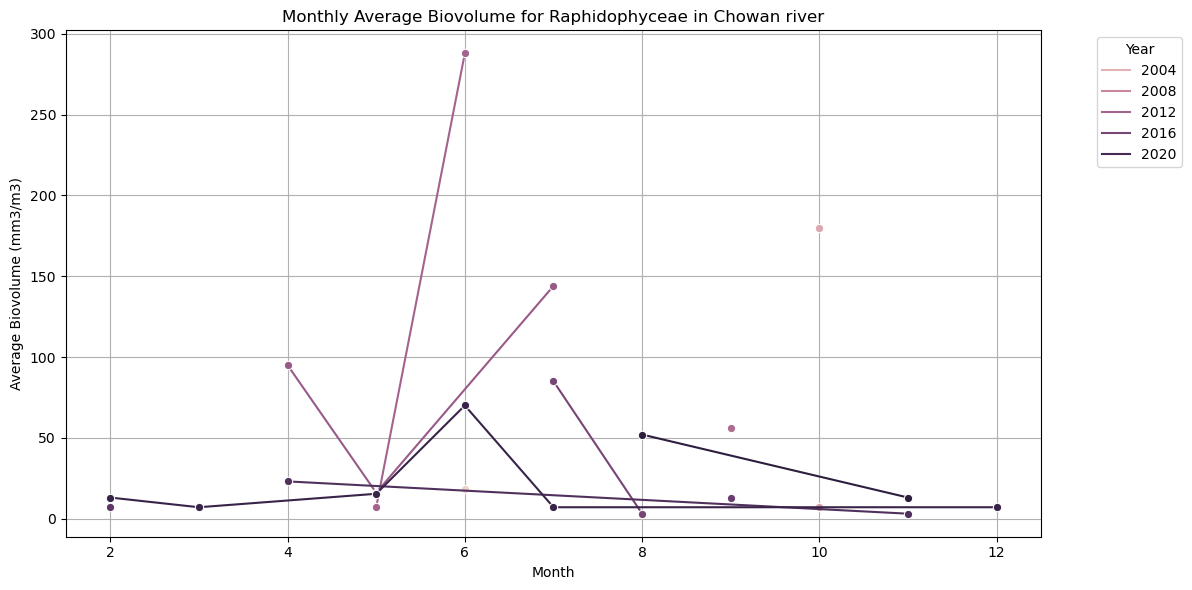

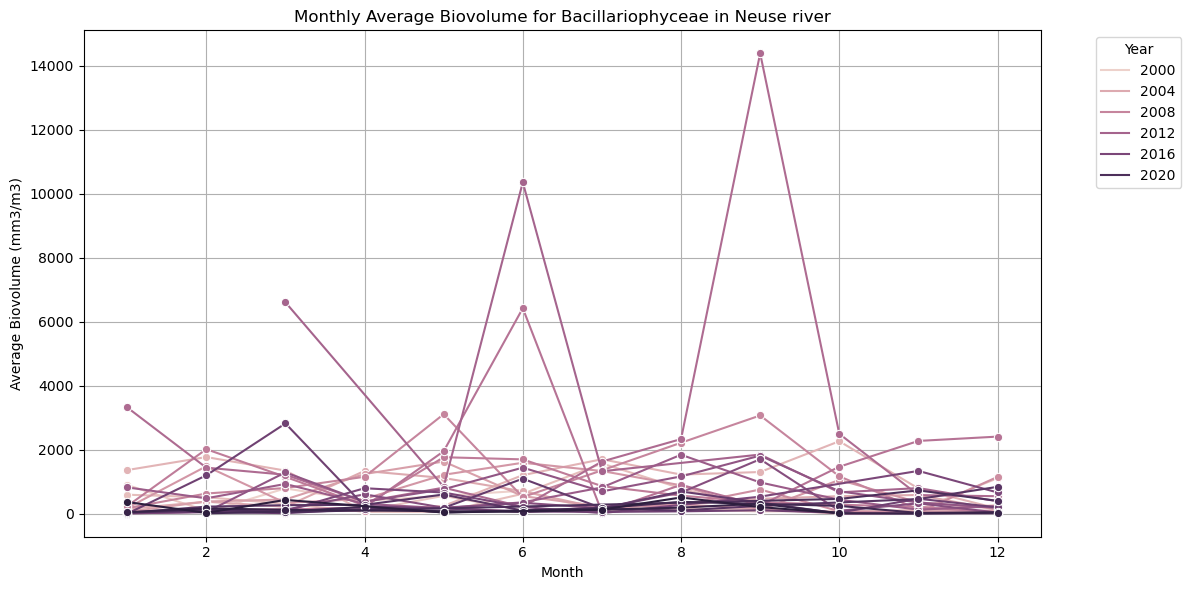

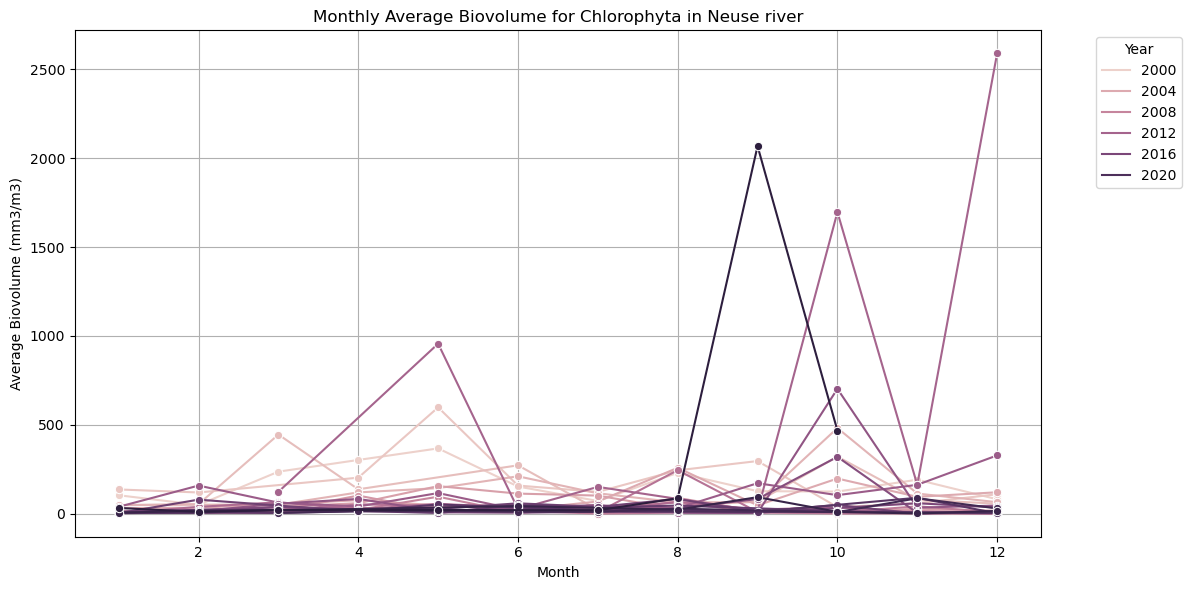

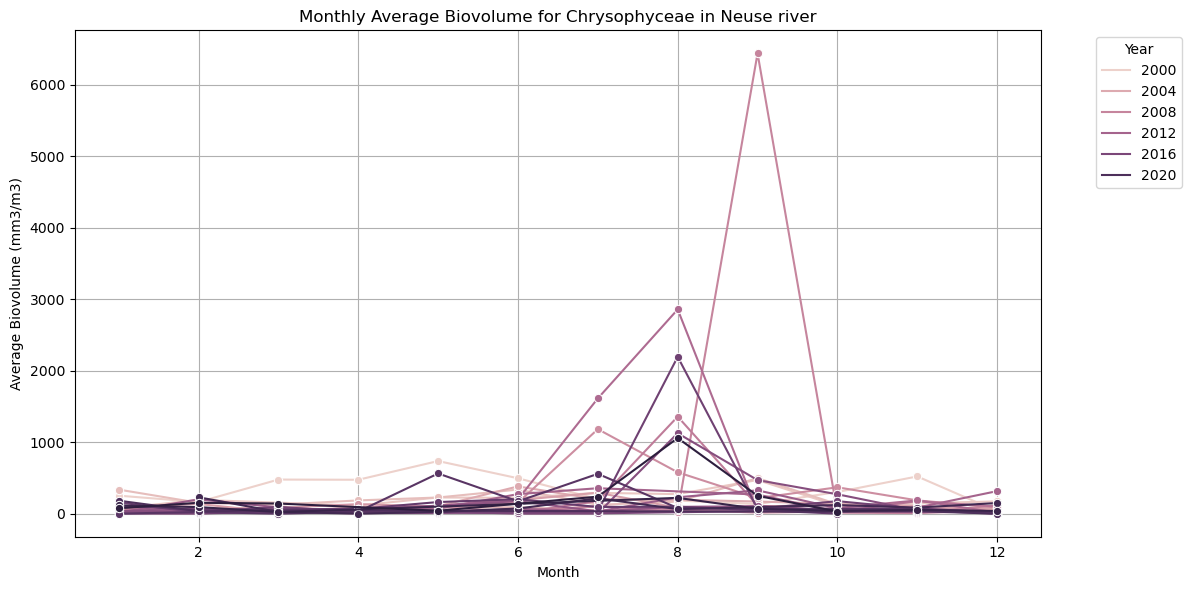

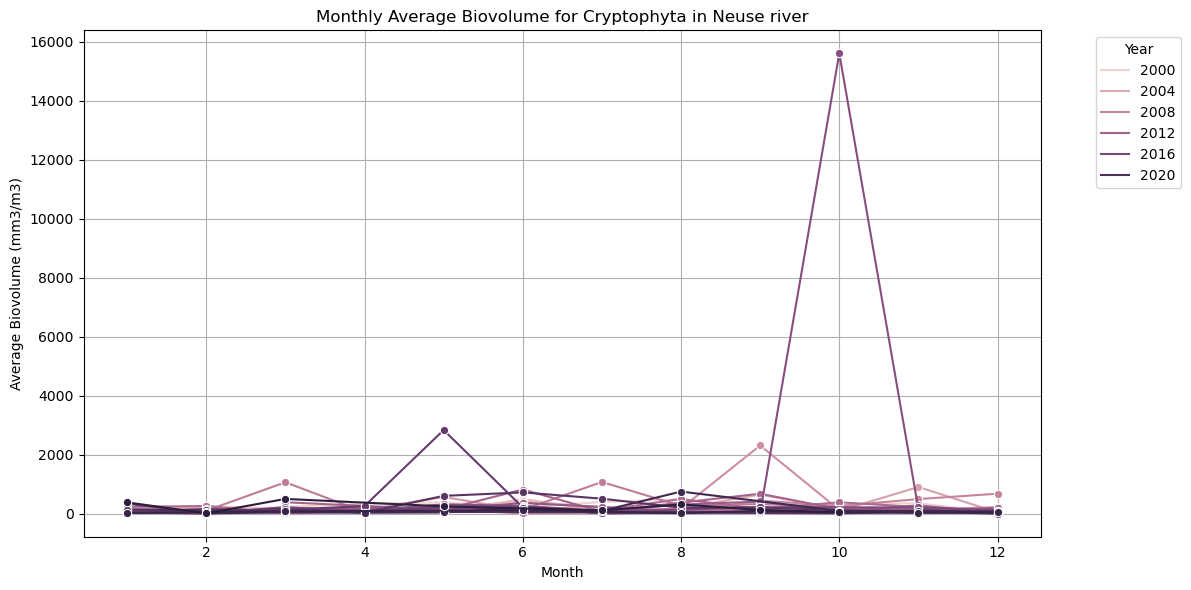

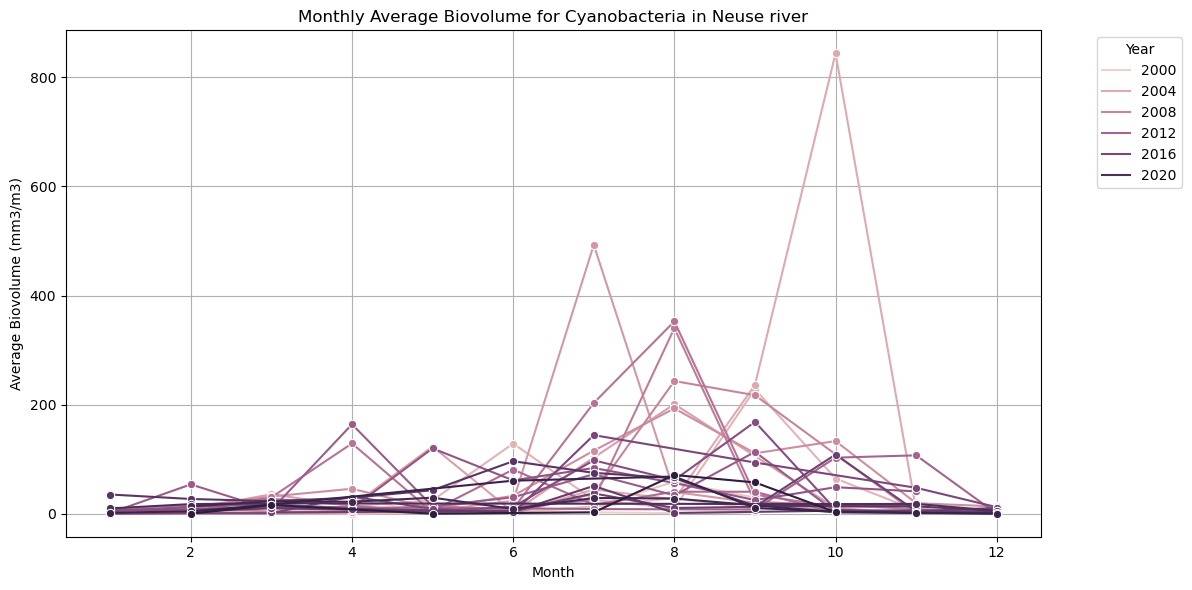

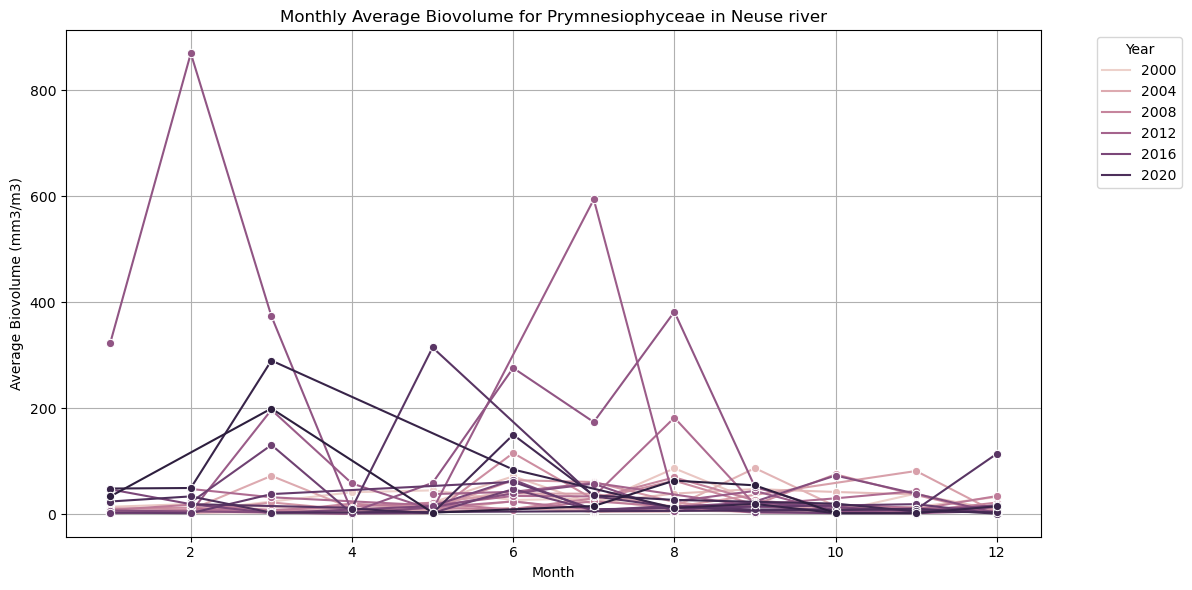

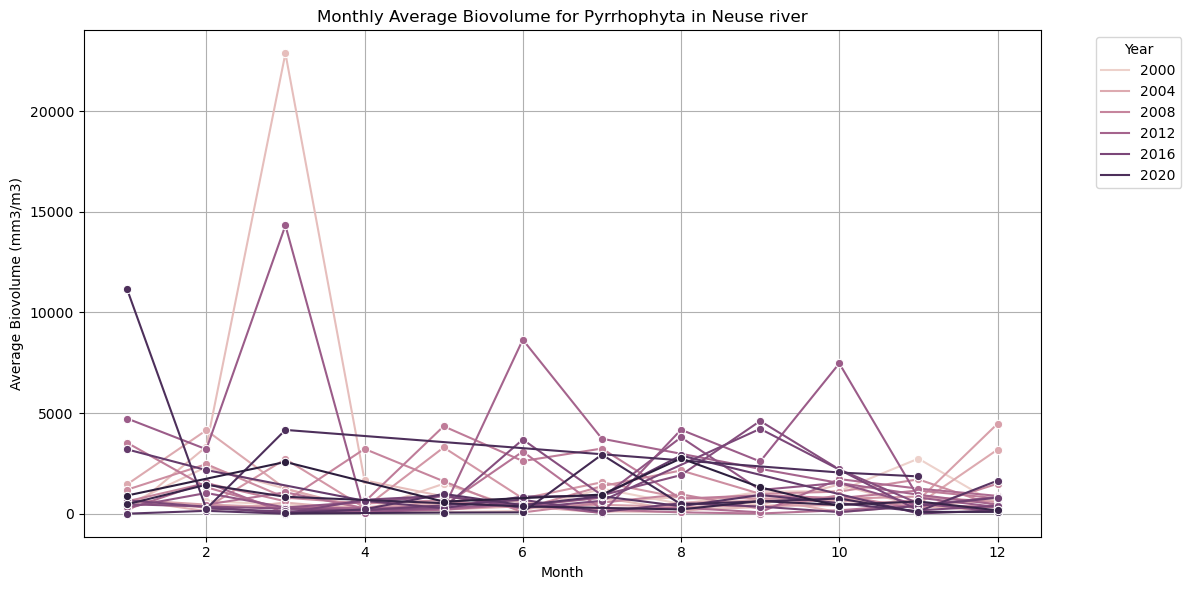

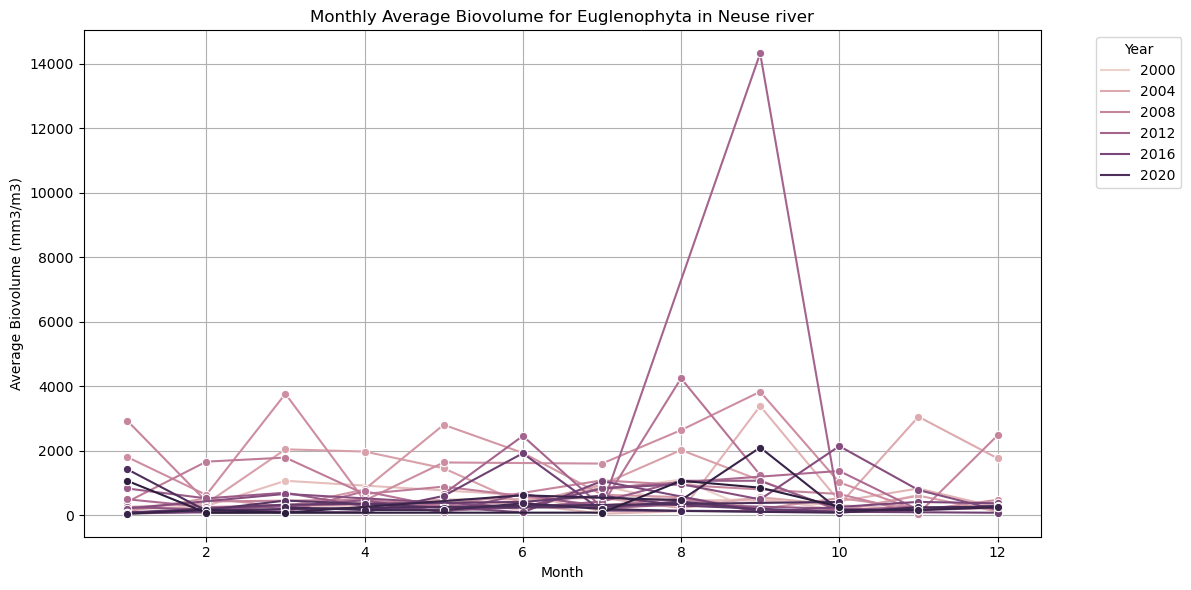

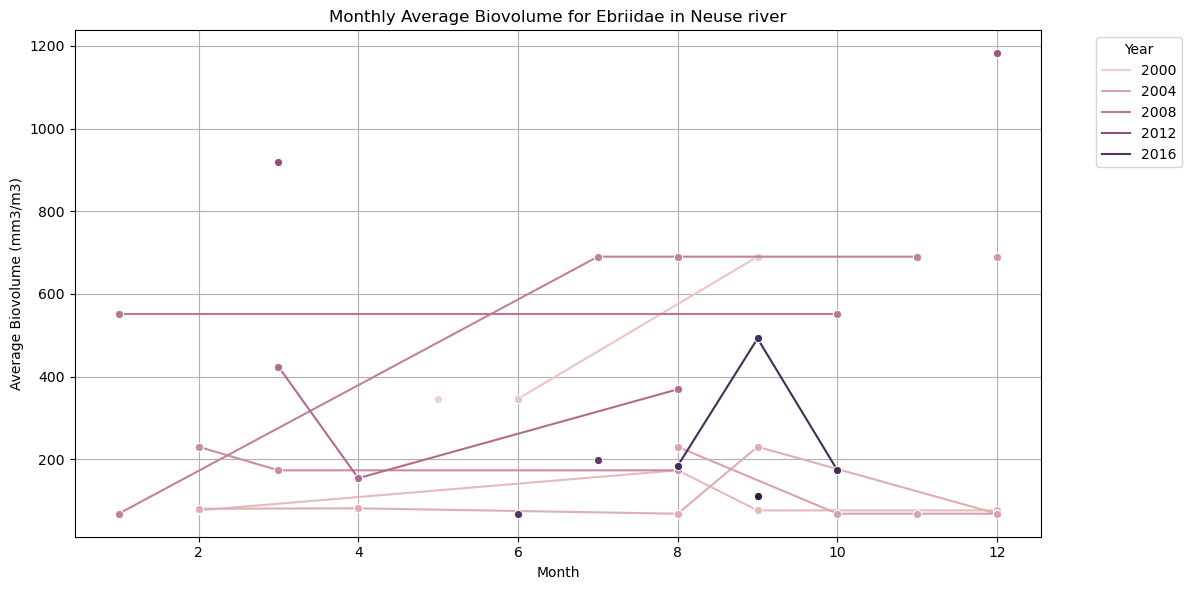

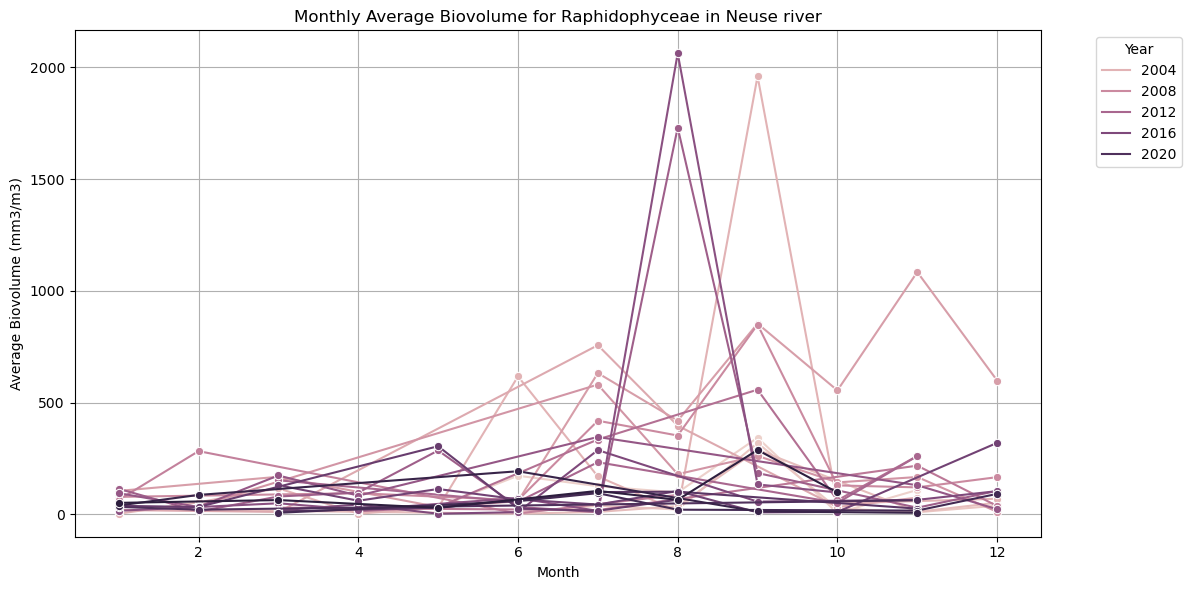

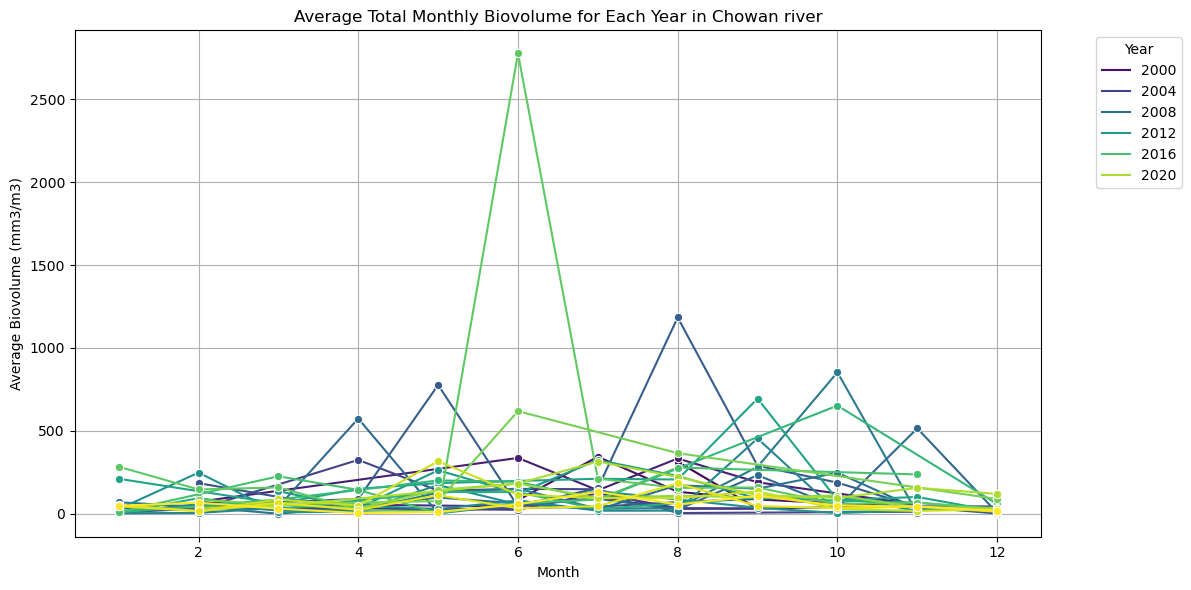

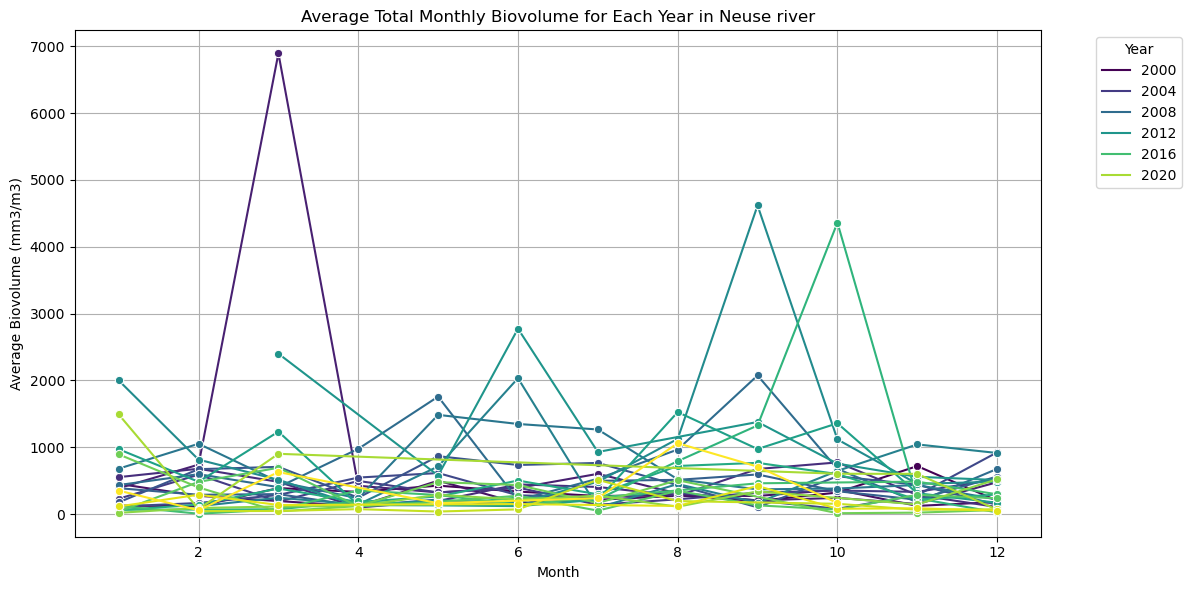

In [23]:
# Filter data for Chowan River and Neuse River only
filtered_data = ALG[ALG['WaterbodyName'].isin(['chowan river', 'neuse river'])]

# Extract year and month from the date for grouping
filtered_data['Year'] = filtered_data['Date'].dt.year
filtered_data['Month'] = filtered_data['Date'].dt.month

# Group by Year, Month, WaterbodyName, and AlgalGroupName and calculate the average Biovolume
monthly_avg_biovolume = filtered_data.groupby(['Year', 'Month', 'WaterbodyName', 'AlgalGroupName'])['Biovolume (mm3/m3)'].mean().reset_index()

# Iterate through each waterbody and algal group combination
for waterbody in monthly_avg_biovolume['WaterbodyName'].unique():
    for algal_group in monthly_avg_biovolume['AlgalGroupName'].unique():
        # Filter data for the current waterbody and algal group
        subset = monthly_avg_biovolume[(monthly_avg_biovolume['WaterbodyName'] == waterbody) & (monthly_avg_biovolume['AlgalGroupName'] == algal_group)]
        
        # Check if the subset is not empty
        if not subset.empty:
            plt.figure(figsize=(12, 6))
            sns.lineplot(data=subset, x='Month', y='Biovolume (mm3/m3)', hue='Year', marker='o')
            plt.title(f'Monthly Average Biovolume for {algal_group} in {waterbody.capitalize()}')
            plt.xlabel('Month')
            plt.ylabel('Average Biovolume (mm3/m3)')
            plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.grid(True)
            plt.tight_layout()
            plt.show()
#############################################################################################################################
# Group by Year, Month, and WaterbodyName to calculate the total average Biovolume across all AlgalGroups
monthly_total_avg_biovolume = filtered_data.groupby(['Year', 'Month', 'WaterbodyName'])['Biovolume (mm3/m3)'].mean().reset_index()

# Iterate through each waterbody
for waterbody in monthly_total_avg_biovolume['WaterbodyName'].unique():
    # Filter data for the current waterbody
    waterbody_data = monthly_total_avg_biovolume[monthly_total_avg_biovolume['WaterbodyName'] == waterbody]
    
    # Plotting
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=waterbody_data, x='Month', y='Biovolume (mm3/m3)', hue='Year', marker='o', palette='viridis')
    plt.title(f'Average Total Monthly Biovolume for Each Year in {waterbody.capitalize()}')
    plt.xlabel('Month')
    plt.ylabel('Average Biovolume (mm3/m3)')
    plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [25]:
#Aggregate the total biovolume for each algal group at each location
total_biovolume_by_group = ALG.groupby(['WaterbodyName', 'AlgalGroupName'])['Biovolume (mm3/m3)'].sum().reset_index()

#Rank the algal groups within each waterbody by their total biovolume
total_biovolume_by_group['Rank'] = total_biovolume_by_group.groupby('WaterbodyName')['Biovolume (mm3/m3)'].rank(method='dense', ascending=False)

#Filter to get the top 3 algal groups for each waterbody
top_algal_groups = total_biovolume_by_group[total_biovolume_by_group['Rank'] <= 3]

# Display the top 3 algal groups for each location
for location in top_algal_groups['WaterbodyName'].unique():
    print(f"Top 3 Algal Groups by Biovolume in {location}:")
    top_groups_in_location = top_algal_groups[top_algal_groups['WaterbodyName'] == location]
    for _, row in top_groups_in_location.iterrows():
        print(f"  {row['AlgalGroupName']} - Biovolume: {row['Biovolume (mm3/m3)']:.2f}, Rank: {int(row['Rank'])}")
    print("\n")
######################################################################################################################
# Calculate total cell biovolume for each algal group in each waterbody
total_biovolume_by_group = ALG.groupby(['WaterbodyName', 'AlgalGroupName'])['Cell Density (cells/ml)'].sum().reset_index()

# Identify the top three algal groups in each waterbody by total biovolume
top_algal_groups_by_location = total_biovolume_by_group.groupby('WaterbodyName').apply(
    lambda x: x.nlargest(3, 'Cell Density (cells/ml)')).reset_index(drop=True)

# Display the top algal groups for verification
print(top_algal_groups_by_location)
# For each location, pivot the data to get monthly biovolume for the top three algal groups
correlation_matrices = {}

for location in top_algal_groups_by_location['WaterbodyName'].unique():
    # Filter the dataset for the current location and top three algal groups
    filtered_data = ALG[
        (ALG['WaterbodyName'] == location) & 
        (ALG['AlgalGroupName'].isin(top_algal_groups_by_location[top_algal_groups_by_location['WaterbodyName'] == location]['AlgalGroupName']))
    ]
    
    # Pivot the data
    biovolume_pivot = filtered_data.pivot_table(
        index=['Year', 'Month'],
        columns='AlgalGroupName',
        values='Cell Density (cells/ml)',
        aggfunc='sum'
    ).fillna(0)
    
    # Calculate the correlation matrix for the top three algal groups
    correlation_matrix = biovolume_pivot.corr()
    correlation_matrices[location] = correlation_matrix
# Display the correlation matrices for each location
for location, corr_matrix in correlation_matrices.items():
    print(f"Correlation Coefficients for {location}:\n{corr_matrix}\n")

Top 3 Algal Groups by Biovolume in chowan river:
  Bacillariophyceae - Biovolume: 95475.00, Rank: 3
  Cyanobacteria - Biovolume: 138891.00, Rank: 1
  Euglenophyta - Biovolume: 116880.00, Rank: 2


Top 3 Algal Groups by Biovolume in falls of the neuse reservoir:
  Chlorophyta - Biovolume: 397.00, Rank: 3
  Cyanobacteria - Biovolume: 780.00, Rank: 1
  Euglenophyta - Biovolume: 656.00, Rank: 2


Top 3 Algal Groups by Biovolume in neuse river:
  Bacillariophyceae - Biovolume: 3464935.00, Rank: 1
  Cryptophyta - Biovolume: 525534.00, Rank: 3
  Pyrrhophyta - Biovolume: 2980911.00, Rank: 2


Top 3 Algal Groups by Biovolume in new river:
  Bacillariophyceae - Biovolume: 5220933.00, Rank: 1
  Euglenophyta - Biovolume: 1337431.00, Rank: 3
  Pyrrhophyta - Biovolume: 3579916.00, Rank: 2


Top 3 Algal Groups by Biovolume in pamlico river:
  Bacillariophyceae - Biovolume: 5224142.00, Rank: 1
  Cyanobacteria - Biovolume: 929321.00, Rank: 3
  Pyrrhophyta - Biovolume: 3332733.00, Rank: 2


Top 3 Algal 